<a href="https://colab.research.google.com/github/Kkuntal990/IB/blob/master/Copy_of_IB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/cleverhans-lab/cleverhans.git

  Cloning https://github.com/cleverhans-lab/cleverhans.git to /tmp/pip-req-build-5dywc6ue
  Running command git clone -q https://github.com/cleverhans-lab/cleverhans.git /tmp/pip-req-build-5dywc6ue
     |████████████████████████████████| 163kB 7.9MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for cleverhans: filename=cleverhans-4.0.0-cp37-none-any.whl size=92450 sha256=950f4fee754c0938a95c3c5994163386d8a60ab6b37b608c76abce739b1ff0d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4_xte3e/wheels/b3/bf/95/b96be44a39afa8756647df63ff1d6592fe799e7b2e03ef437c
Successfully built cleverhans


In [12]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.metrics import confusion_matrix
#import plotcm
import sys
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, ZeroPadding2D
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten, Lambda
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.models as models
import numpy as np
import os
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/IB/RML2016.10a_dict.dat" /content/

In [4]:
#import cPickle

os.environ["KERAS_BACKEND"] = "tensorflow"
sys.path.append('../confusion')

name = 'CNN2'

In [5]:
with open("RML2016.10a_dict.dat", 'rb') as xd1:  
    Xd = pickle.load(xd1, encoding='latin1')  # , encoding='latin1'
snrs, mods = map(lambda j: sorted(
    list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = []
lbl = []
SNR = []
MODU = []
k=0
for mod in mods:
    k+=1
    for snr in snrs:
        SNR.append(snr)
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):
            lbl.append((mod, snr))
            MODU.append(i)
X = np.vstack(X)
# %%
np.random.seed(2016)  
n_examples = X.shape[0]
n_train = n_examples * 0.5  # ĺŻšĺ
train_idx = np.random.choice(
    range(0, n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))  # label
test_idx2 = []
X_train = X[train_idx]
for i in test_idx:
    if SNR[i//1000] == 10:
        test_idx2.append(i)
 
X_test = X[test_idx2]
MODU = np.array(MODU)


In [6]:
print(X_test.shape)

(5490, 2, 128)


In [7]:
ii = np.random.randint(0,X_train.shape[0])
print(ii)
t = np.arange(X_train.shape[2])
plt.plot(t, X_train[i, 0, :])
plt.plot(t, X_train[i, 1, :])
plt.show()

24420


IndexError: ignored

In [8]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1


trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx2)))
# %%
in_shp = list(X_train.shape[1:])
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
classes = mods
print(in_shp)


(110000, 2, 128) (5490, 2, 128)
(110000, 11) (5490, 11)
[2, 128]


In [9]:
import tensorflow as tf
from tensorflow_probability import distributions as ds
import math

In [10]:
# def sample_z(args):
#   mu, sigma = args
#   batch = K.shape(mu)[0]
#   dim = K.int_shape(mu)[1]
#   eps = K.random_normal(shape=(batch, dim))
#   return mu + K.log(1 + K.exp(sigma - 5.0)) * eps

BETA = 2*1e-3
prior = ds.Normal(0.0, 1e0)
dr = 0.0

In [11]:
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        inp = keras.Input(shape=(2,128,))
        x = Reshape(target_shape=(2,128,1,), name = "re1")(inp)
        x = ZeroPadding2D((0,2), data_format="channels_first")(x)
        x = Conv2D(256, (1, 3), padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform')(x)
        x = Dropout(dr)(x)
        x = ZeroPadding2D((0, 2), data_format="channels_first")(x)
        x = Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2",kernel_initializer='glorot_uniform')(x)
        x = Dropout(dr)(x)
        x = Flatten()(x)
        x = Dense(512, activation='relu', name="mu",kernel_initializer='he_normal')(x)
        '''
        mu = Dense(128, activation='relu', name="mu")(x)
        mu = Dropout(dr)(mu)

        sigma = Dense(128, activation='relu', name="sigma")(x)
        sigma = Dropout(dr)(sigma)
        '''
        mu, sigma = x[:, :256], x[:, 256:]
        #z = keras.layers.Lambda(sample_z, output_shape=(256, ), name='z')([mu, sigma])
        encoder = keras.Model(inp, [mu,sigma], name="encoder")
        self.encoder = encoder
        z = keras.Input(shape=(256,))
        y = Dense(len(classes), name="dense3", activation='relu',kernel_initializer='he_normal')(z)
        decoder = keras.Model(z,y, name="decoder")
        self.decoder = decoder
        self.encoder.summary()
        self.decoder.summary()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.val_loss_tracker = keras.metrics.Mean(name="val_loss")
        self.class_loss_tracker = keras.metrics.Mean(
             name="class_loss"
         )
        self.info_loss_tracker = keras.metrics.Mean(name="info_loss")
        self.IZY_bound_tracker = keras.metrics.Mean(name="IZY_bound")
        self.IZX_bound_tracker = keras.metrics.Mean(name="IZX_bound")
        self.train_acc_tracker = keras.metrics.Mean(name="Training accuracy")
        self.val_acc_tracker = keras.metrics.Mean(name="validation accuracy")

    @property
    def metrics(self):
        return [
            self.class_loss_tracker,
            self.info_loss_tracker,
            self.total_loss_tracker,
            self.IZY_bound_tracker,
            self.IZX_bound_tracker
            ,self.train_acc_tracker
        ]

    def call(self, data):
      mu,sigma = self.encoder(data)
      sigma = tf.math.softplus(sigma-5.0)
      z_dist = ds.Normal(mu, sigma)
      z = z_dist.sample()
      y = self.decoder(z)
      return tf.nn.softmax(y)

    @tf.function
    def train_step(self, inp):
        data, y_true = inp
        with tf.GradientTape() as tape:
            mu,sigma = self.encoder(data)
            sigma = tf.math.softplus(sigma-5.0)
            z_dist = ds.Normal(mu, sigma)
            z = z_dist.sample()
            y = self.decoder(z)
            
          
            info_loss = tf.reduce_sum(tf.reduce_mean(ds.kl_divergence(z_dist, prior), 0)) /math.log(2)
            class_loss = tf.compat.v1.losses.softmax_cross_entropy(logits=y, onehot_labels=y_true)
            total_loss =  class_loss + BETA*info_loss
        training_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_true, axis=1)), tf.float32))
        IZY_bound =  math.log(10, 2) - class_loss
        IZX_bound = info_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.class_loss_tracker.update_state(class_loss)
        self.info_loss_tracker.update_state(info_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.IZY_bound_tracker.update_state(IZY_bound)
        self.IZX_bound_tracker.update_state(IZX_bound)
        self.train_acc_tracker.update_state(training_acc)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "info_loss": self.info_loss_tracker.result(),
            "class_loss": self.class_loss_tracker.result(),
            "IZY_bound" : self.IZY_bound_tracker.result(),
            "IZX_bound" : self.IZX_bound_tracker.result()
            ,"Train acc" : self.train_acc_tracker.result()
        }
    @tf.function
    def test_step(self, val_inp):
        x_val, y_val = val_inp
        mu,sigma = self.encoder(x_val)
        sigma = tf.math.softplus(sigma-5)
        z_dist = ds.Normal(mu, sigma)
        z = z_dist.sample()
        y = self.decoder(z)
        info_loss = tf.reduce_sum(tf.reduce_mean(ds.kl_divergence(z_dist, prior), 0)) /math.log(2)
        class_loss = tf.compat.v1.losses.softmax_cross_entropy(logits=y, onehot_labels=y_val)
        val_loss =  class_loss + BETA*info_loss
        val_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(tf.nn.softmax(y), 1), tf.argmax(y_val, axis=1)), tf.float32))
        self.val_loss_tracker.update_state(val_loss)
        self.val_acc_tracker.update_state(val_acc)
        return {
            "acc" : self.val_acc_tracker.result(),
            "loss" : self.val_loss_tracker.result()
        }



In [36]:
vae = VAE()

activations_list = [] #[epoch][layer][0][X][unit]

def save_activations(vae):
    encoder = vae.encoder
    decoder = vae.decoder
    eoutputs = [layer.output for layer in encoder.layers]
    doutputs = [layer.output for layer in decoder.layers]
    functors = [K.function([encoder.input],[out]) for out in eoutputs]
    #functors += [K.function([decoder.input],[out]) for out in doutputs]
    layer_activations = [f([X_train[:100]]) for f in functors]
    activations_list.append(layer_activations)

activations_callback = LambdaCallback(on_epoch_end = lambda batch, logs:save_activations(vae))

weights_list = [] 

def save_weights(vae):
    inner_list = []
    for layer in vae.layers:
        inner_list.append(layer.get_weights()[0])
    weights_list.append(inner_list)

weights_callback = LambdaCallback(on_epoch_end = lambda batch, logs:save_weights(vae))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 2, 128, 1)    0           input_21[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_20 (ZeroPadding2 (None, 2, 128, 5)    0           reshape_10[0][0]                 
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 2, 126, 256)  4096        zero_padding2d_20[0][0]          
____________________________________________________________________________________________

In [37]:
vae.compile(optimizer=keras.optimizers.Adam(lr=5e-4), metrics=[tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')])
history = vae.fit(X_train,Y_train,validation_data=(X_test, Y_test), epochs=1000, batch_size=1024, callbacks = [activations_callback])

Epoch 1/1000
108/108 [==============================] - 10s 88ms/step - loss: 4.0743 - info_loss: 416.8896 - class_loss: 2.4561 - IZY_bound: 0.8658 - IZX_bound: 416.8896 - Train acc: 0.0933 - val_acc: 0.0854 - val_loss: 2.8106
Epoch 2/1000
108/108 [==============================] - 9s 88ms/step - loss: 2.7955 - info_loss: 182.8399 - class_loss: 2.4200 - IZY_bound: 0.9019 - IZX_bound: 182.8399 - Train acc: 0.0887 - val_acc: 0.0892 - val_loss: 2.7883
Epoch 3/1000
108/108 [==============================] - 10s 88ms/step - loss: 2.7661 - info_loss: 175.8383 - class_loss: 2.4103 - IZY_bound: 0.9116 - IZX_bound: 175.8383 - Train acc: 0.0903 - val_acc: 0.0884 - val_loss: 2.7773
Epoch 4/1000
 59/108 [===============>..............] - ETA: 4s - loss: 2.7550 - info_loss: 173.4978 - class_loss: 2.4072 - IZY_bound: 0.9148 - IZX_bound: 173.4978 - Train acc: 0.0907

KeyboardInterrupt: ignored

In [41]:
len(activations_list)

3

In [ ]:
vae.predict(X_test)
vae.save("/content/drive/MyDrive/IB_checkpoints/checkpoint_final_1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IB_checkpoints/checkpoint3/assets


In [ ]:
vib = tf.keras.models.load_model('/content/drive/MyDrive/IB_checkpoints/TrainedModel2')
cnn2 = tf.keras.models.load_model('/content/drive/MyDrive/IB_checkpoints/OGCNN2')

In [ ]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [ ]:
n_tests = 10000
testidx = np.random.randint(low=0, high=len(X_test), size=min(n_tests, len(X_test)), dtype=np.int32)

In [ ]:
X_A1 = fast_gradient_method(vib, X_test[testidx], 0.0, np.inf)
Y_A1 = np.argmax(vib(X_A1), axis=1)
print(Y_A1[:5], np.argmax(Y_test[testidx][:5],axis=1))
print(np.sum(Y_A1 == np.argmax(Y_test[testidx],axis=1))/n_tests)

[] []
0.0


In [ ]:
X_A2 = fast_gradient_method(cnn2, X_test[testidx], 0, np.inf)
Y_A2 = np.argmax(vib(X_A2), axis=1)
print(Y_A2[:5], np.argmax(Y_test[testidx][:5],axis=1))
print(np.sum(Y_A2 == np.argmax(Y_test[testidx],axis=1))/n_tests)

[2 6 4 8 8] [0 0 0 0 0]
0.081


In [ ]:
acc_CNN = []
acc_VIB = []
for ep in np.linspace(0.000, 0.02, 40):
    X_A2 = fast_gradient_method(cnn2, X_test[testidx], ep, np.inf)
    Y_A2 = np.argmax(vib(X_A2), axis=1)
    X_A1 = f ast_gradient_method(vib, X_test[testidx], ep, np.inf)
    Y_A1 = np.argmax(vib(X_A1), axis=1)
    acc_CNN.append(np.sum(Y_A2 == np.argmax(Y_test[testidx],axis=1))/n_tests)
    acc_VIB.append(np.sum(Y_A1 == np.argmax(Y_test[testidx],axis=1))/n_tests)

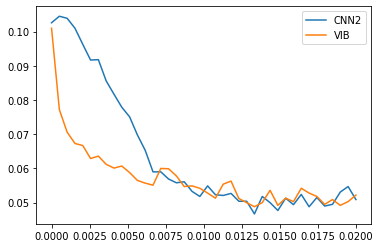

In [ ]:
plt.plot(np.linspace(0.000, 0.02, 40), acc_CNN, label="CNN2")
plt.plot(np.linspace(0.000, 0.02, 40), acc_VIB, label="VIB")
plt.legend()
plt.show()

In [ ]:
encoder = vae.encoder
decoder = vae.decoder

In [ ]:
enw = encoder.get_weights()

In [ ]:
for i in range(len(enw)):
  print(enw[i].shape)

(1, 3, 5, 256)
(256,)
(2, 3, 260, 80)
(80,)
(9920, 512)
(512,)


In [ ]:
enw[0][:,:,0,0]

array([[ 0.07717382,  0.00115035, -0.00671841]], dtype=float32)

0


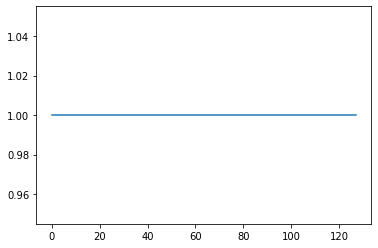

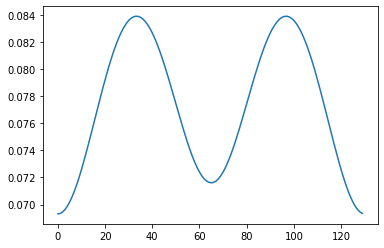





1


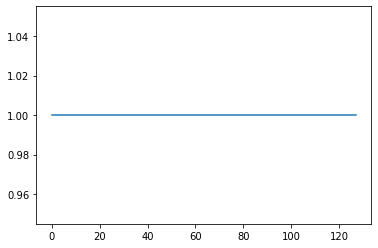

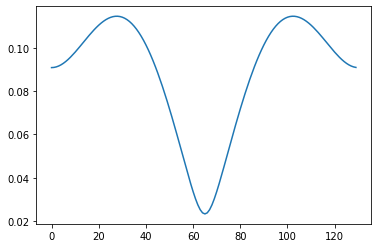





2


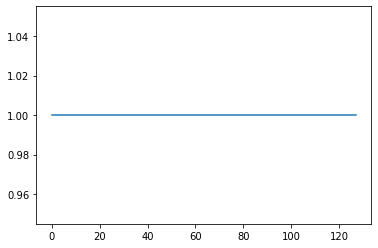

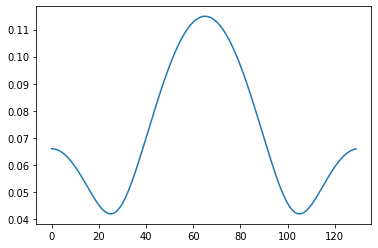





3


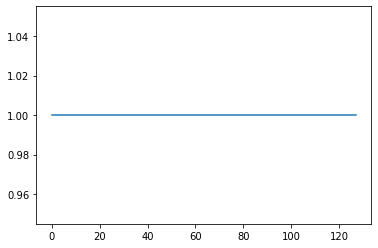

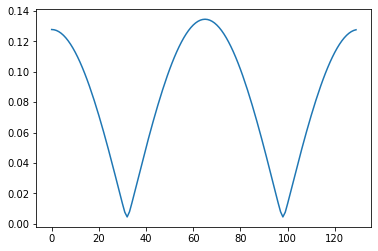





4


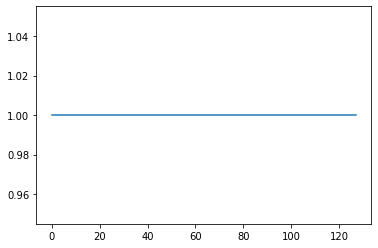

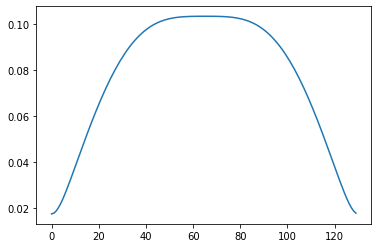





5


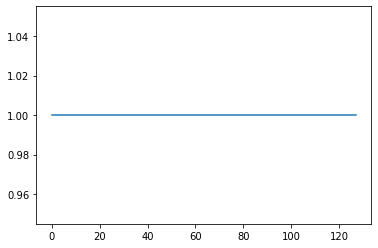

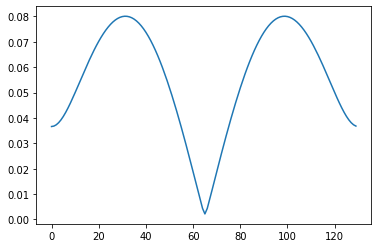





6


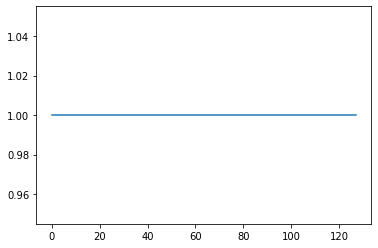

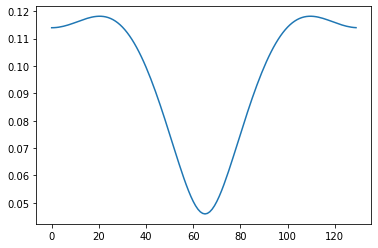





7


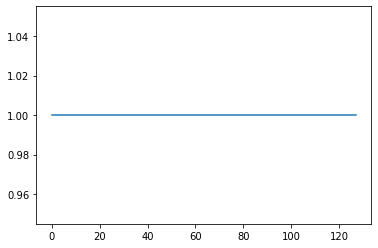

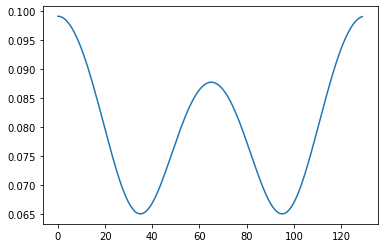





8


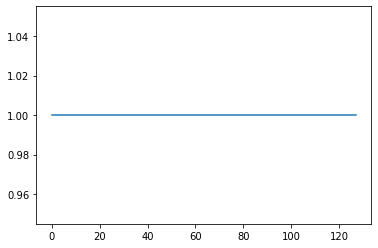

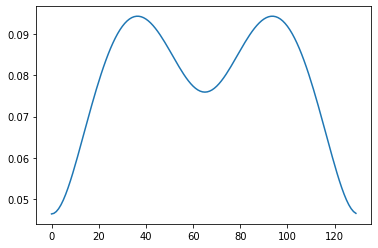





9


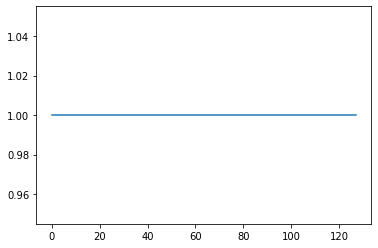

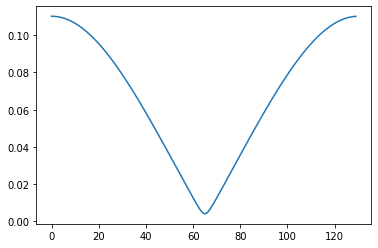





10


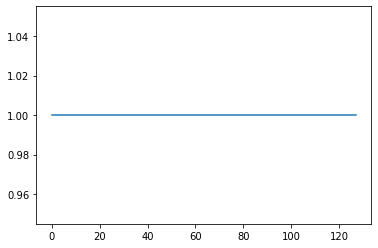

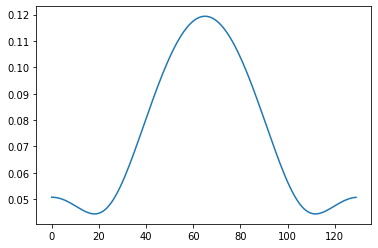





11


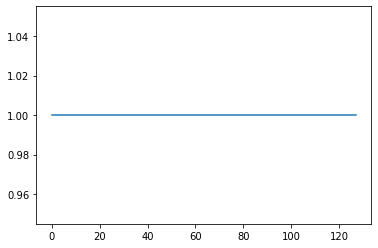

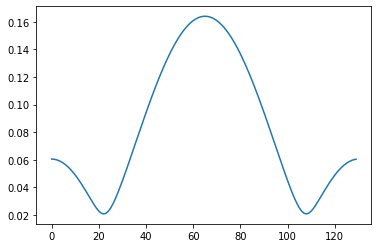





12


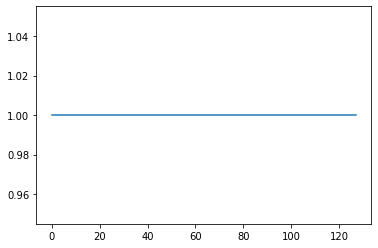

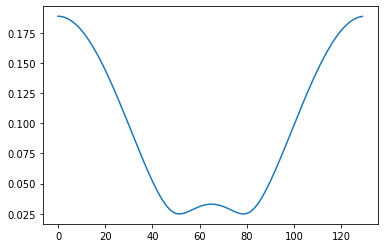





13


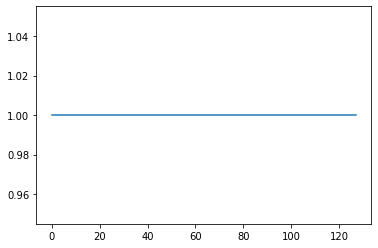

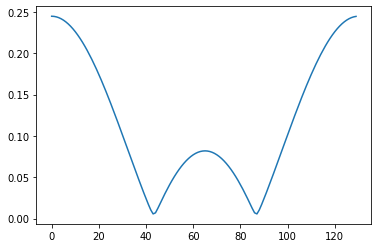





14


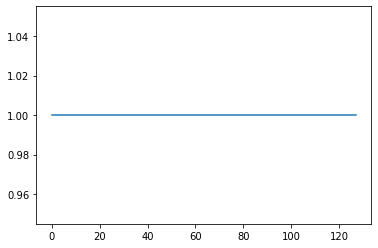

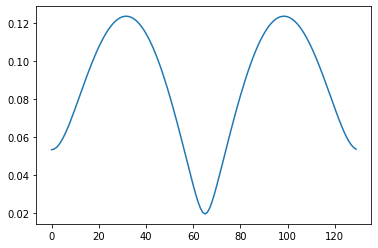





15


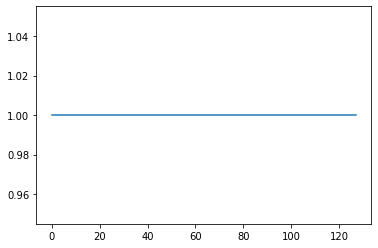

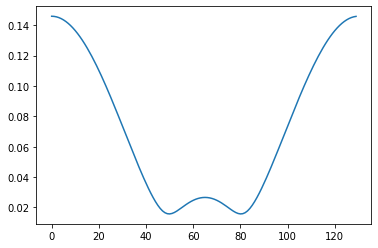





16


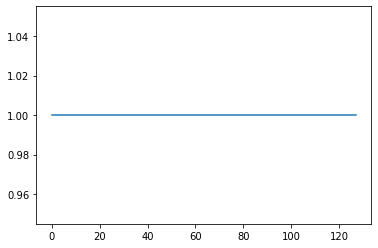

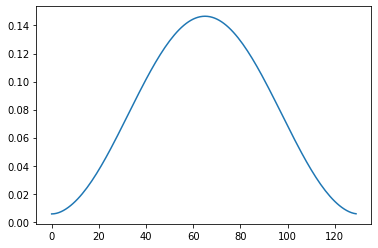





17


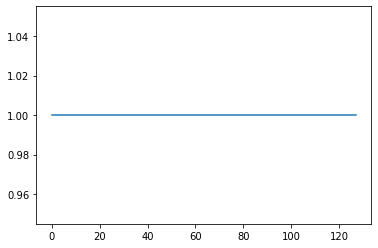

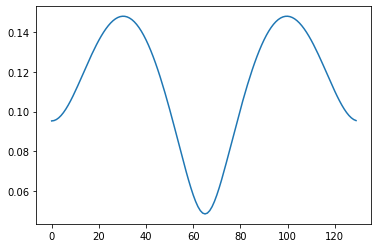





18


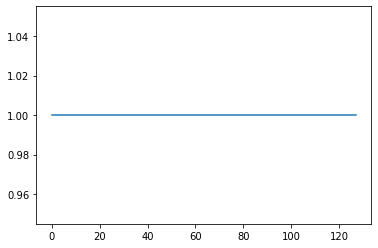

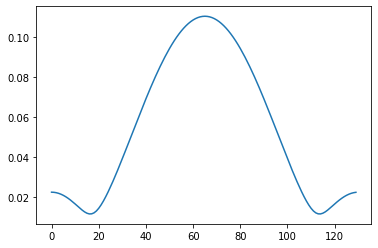





19


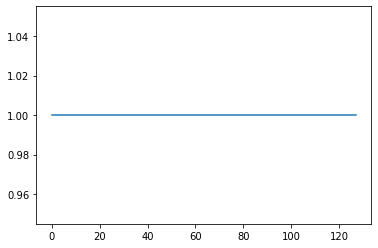

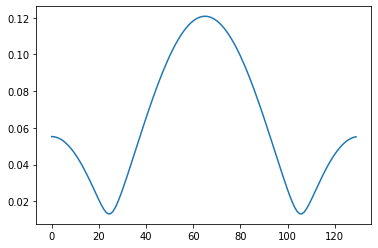





20


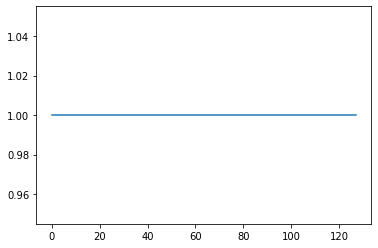

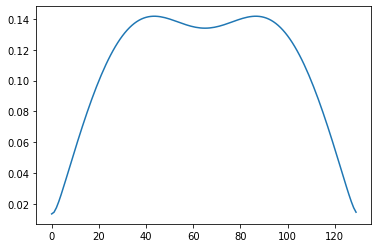





21


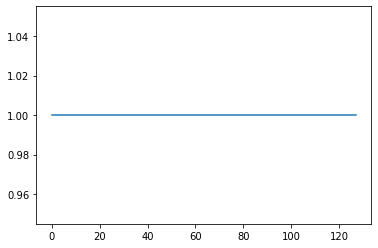

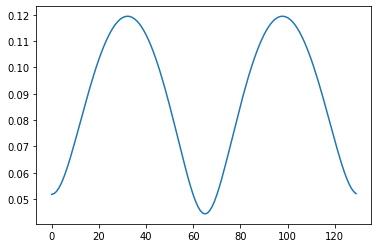





22


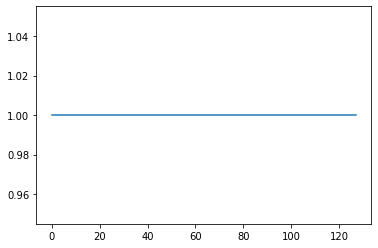

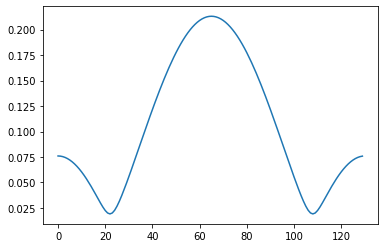





23


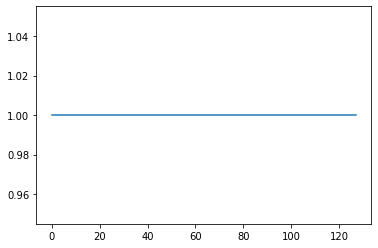

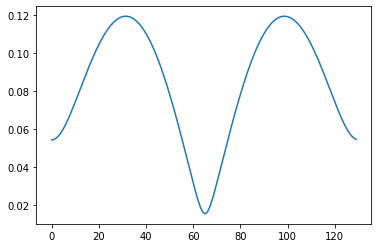





24


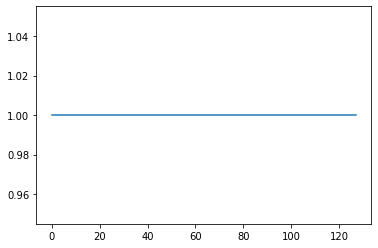

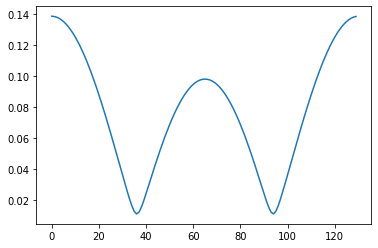





25


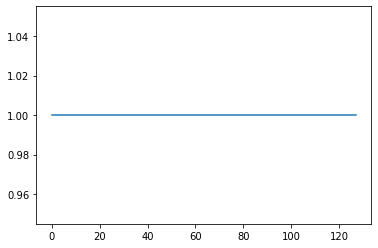

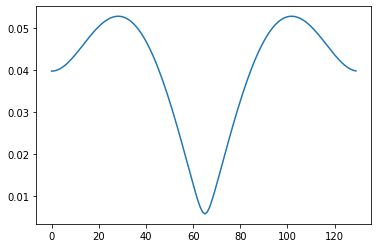





26


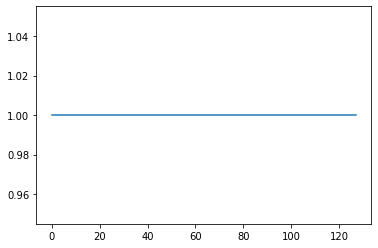

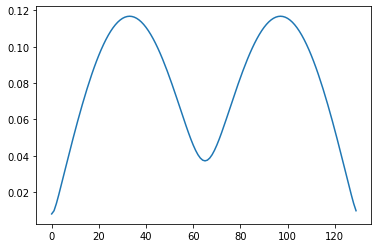





27


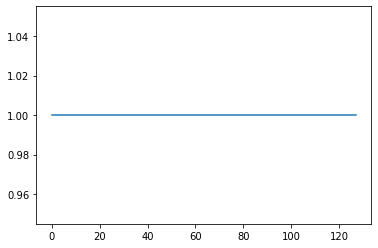

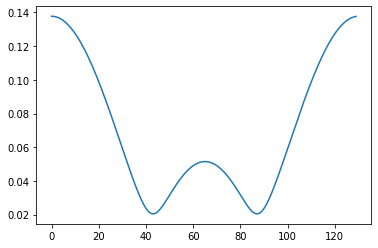





28


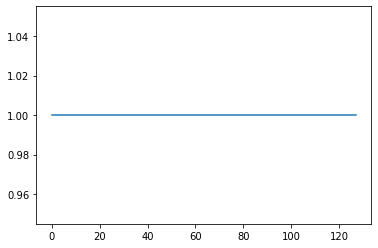

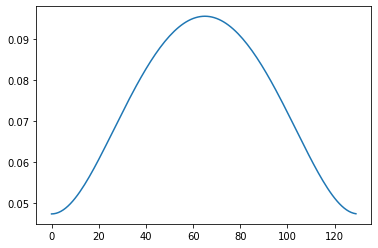





29


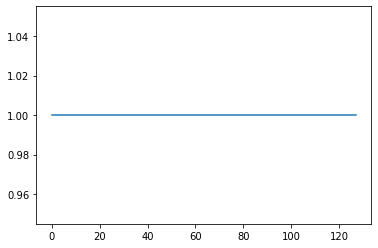

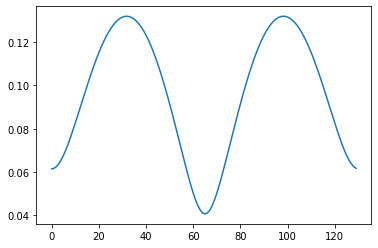





30


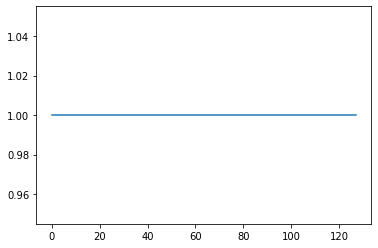

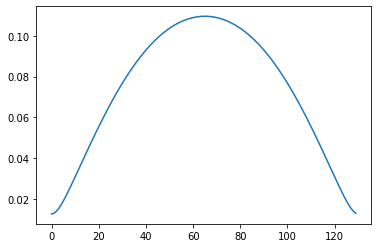





31


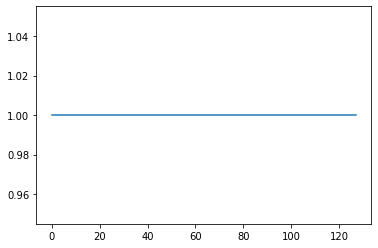

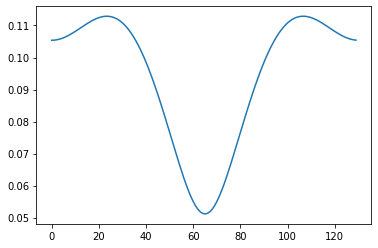





32


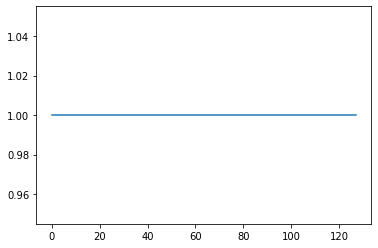

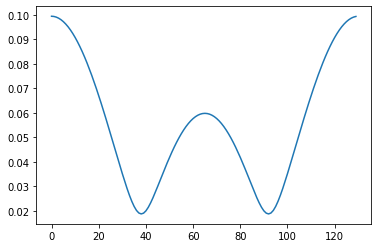





33


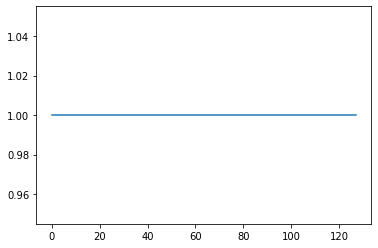

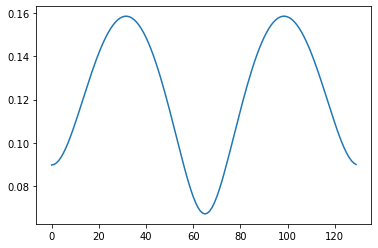





34


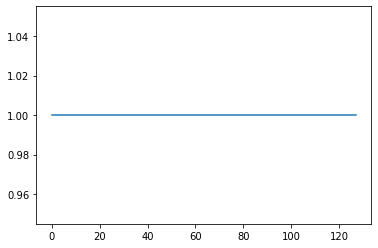

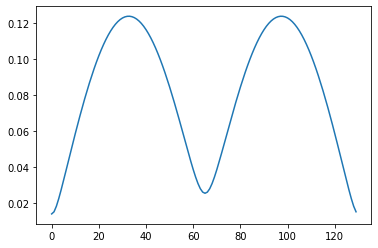





35


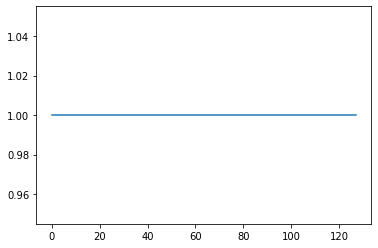

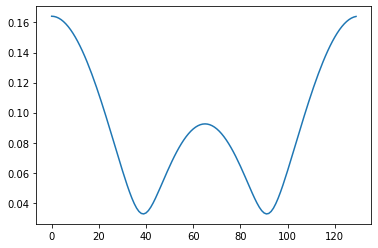





36


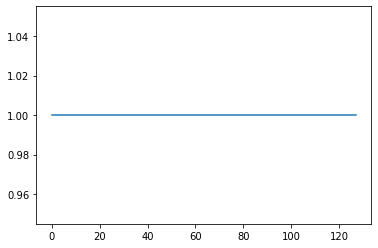

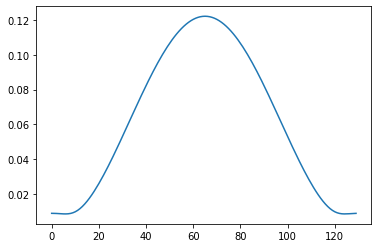





37


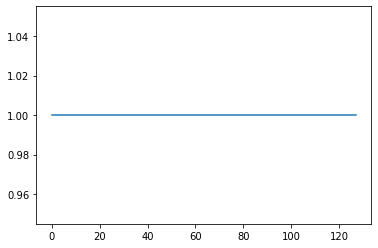

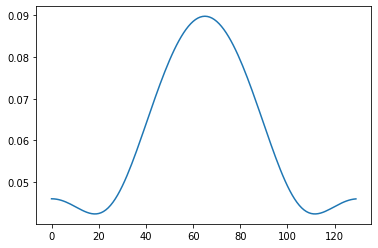





38


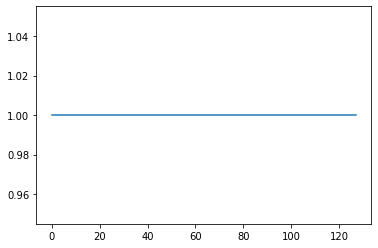

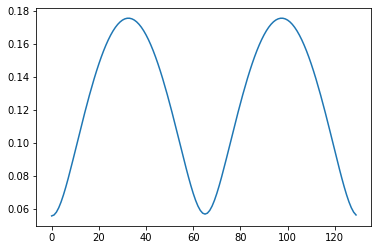





39


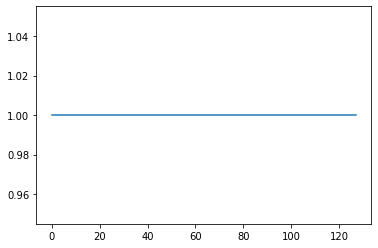

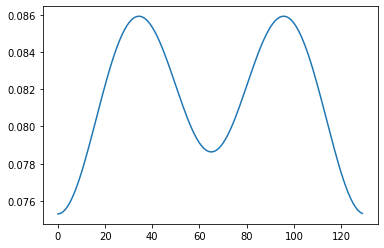





40


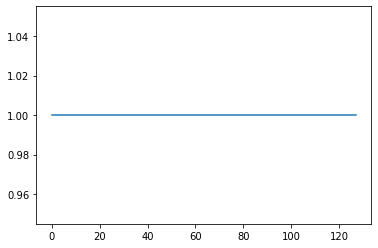

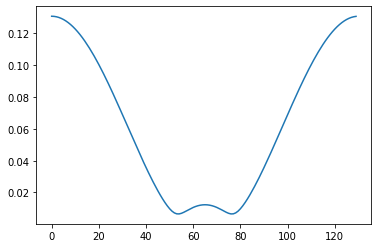





41


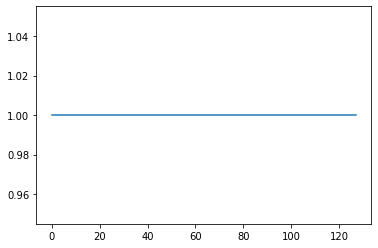

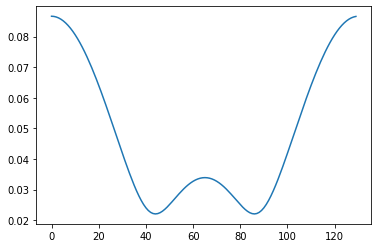





42


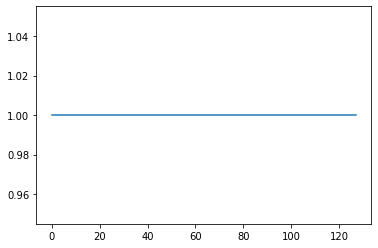

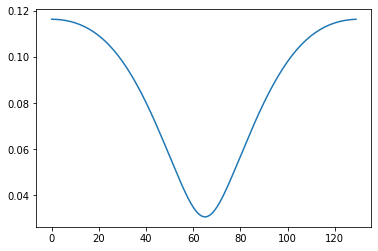





43


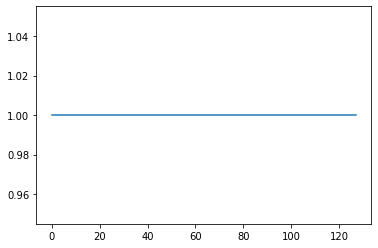

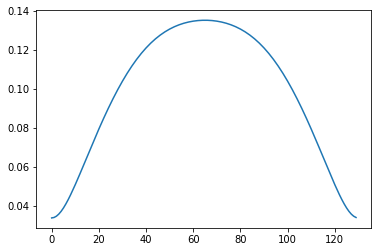





44


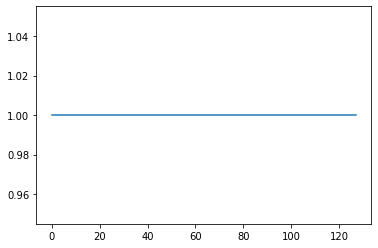

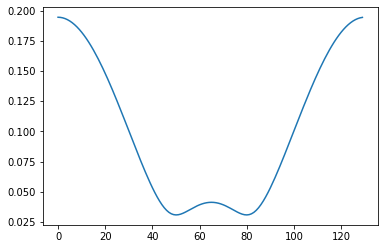





45


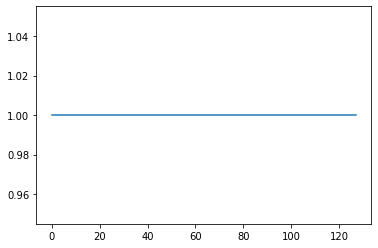

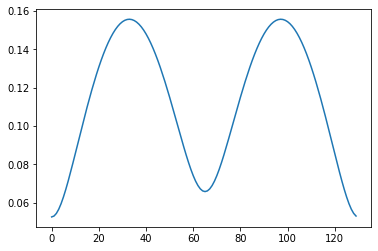





46


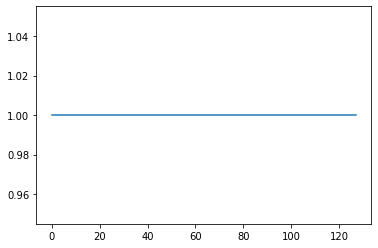

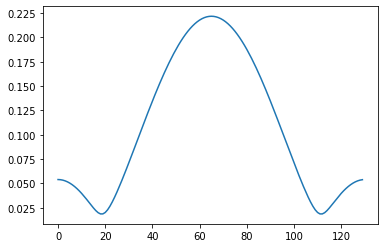





47


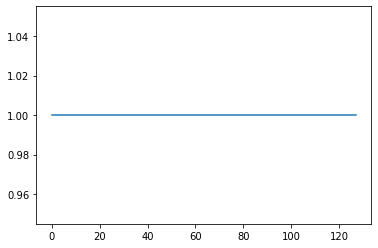

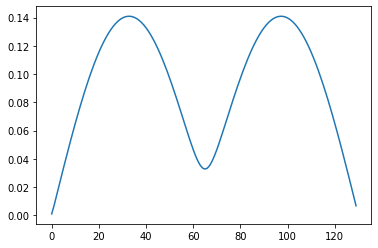





48


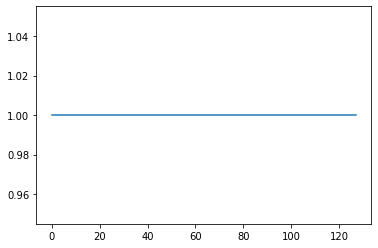

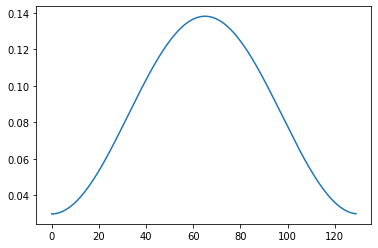





49


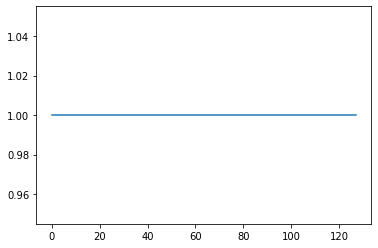

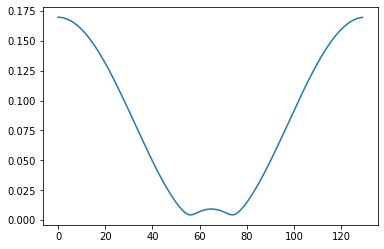





50


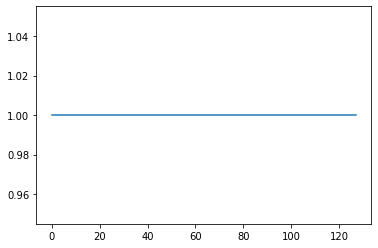

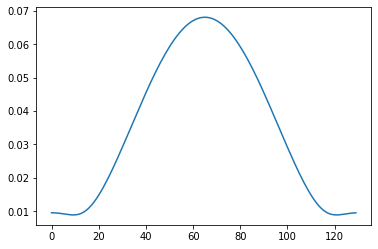





51


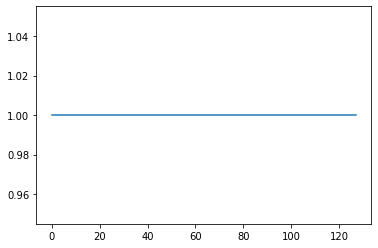

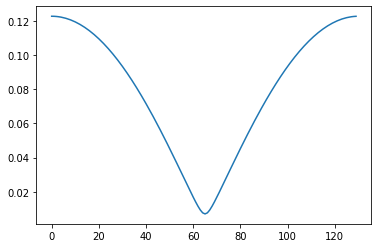





52


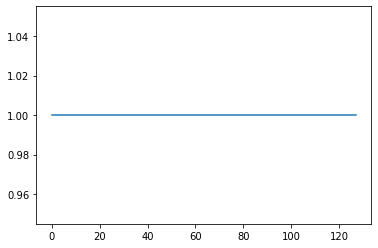

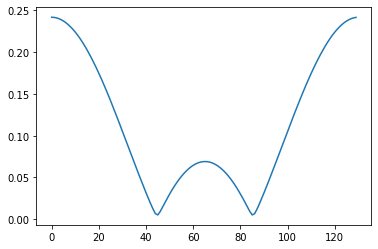





53


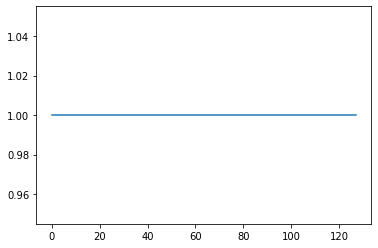

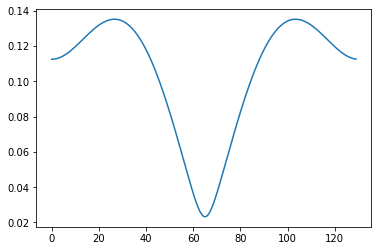





54


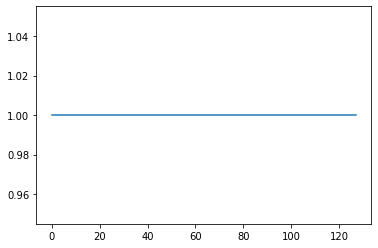

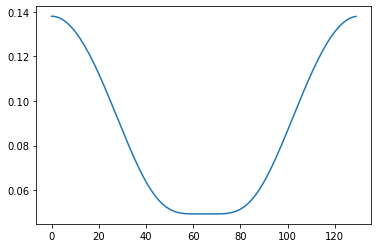





55


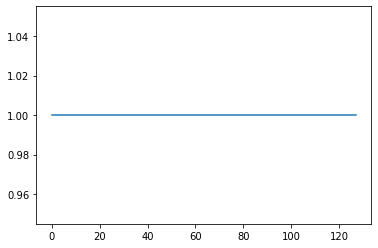

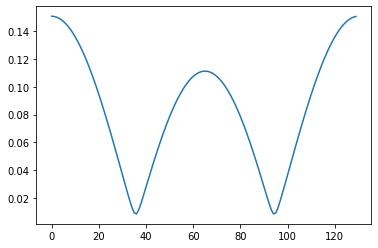





56


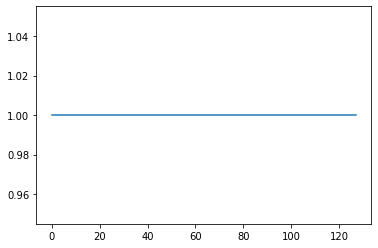

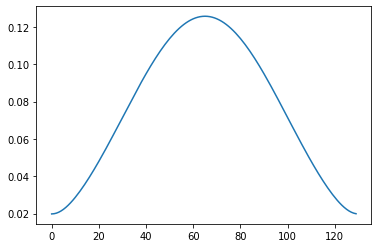





57


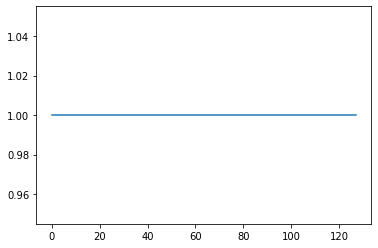

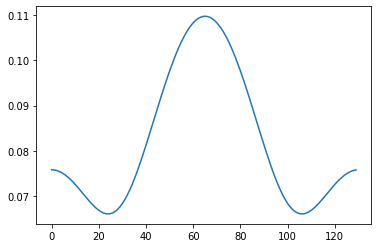





58


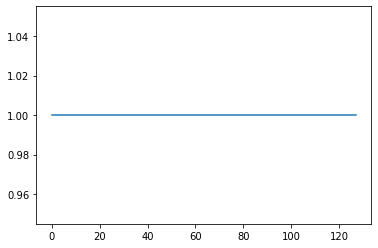

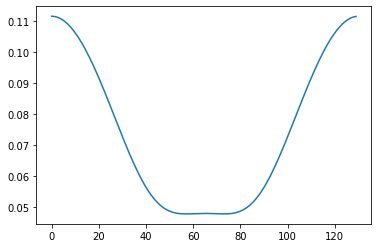





59


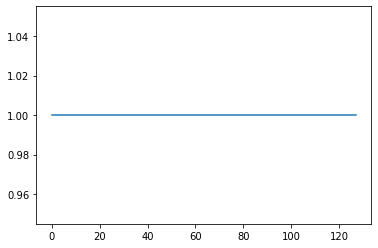

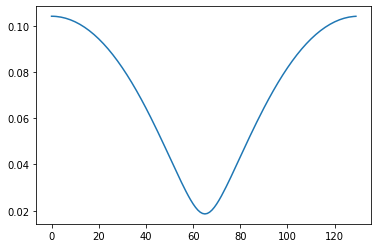





60


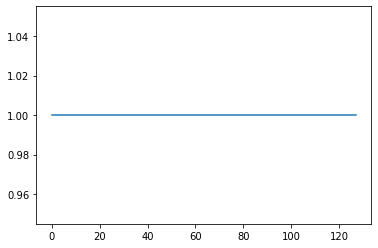

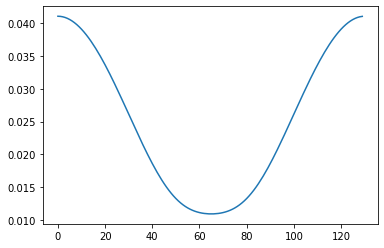





61


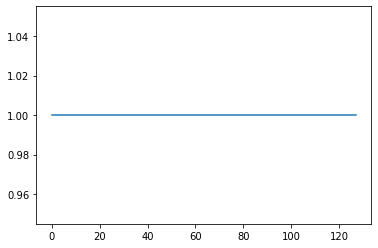

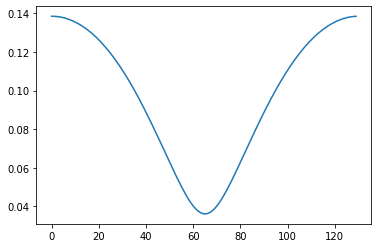





62


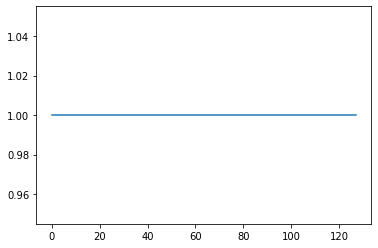

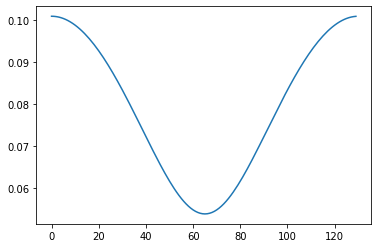





63


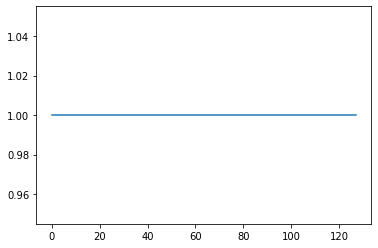

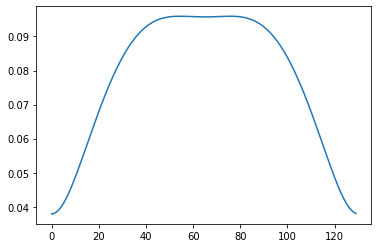





64


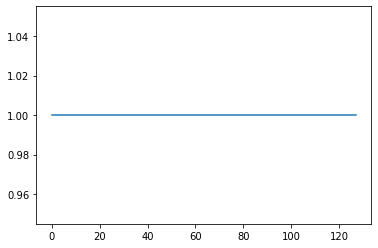

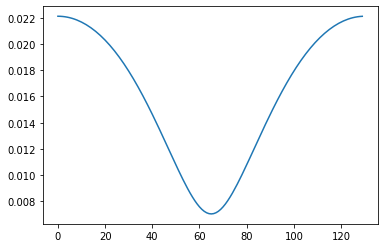





65


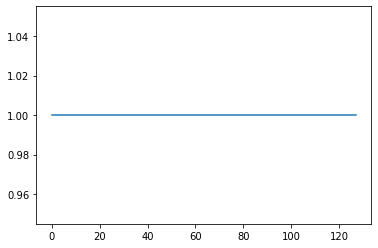

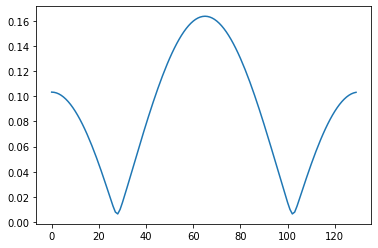





66


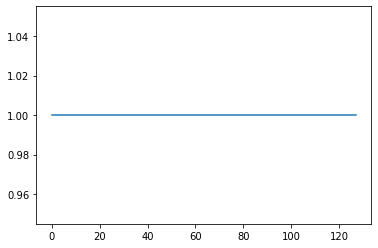

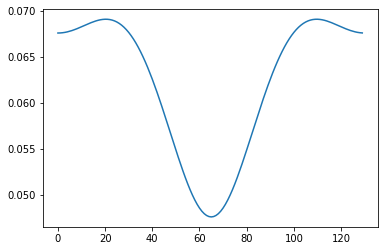





67


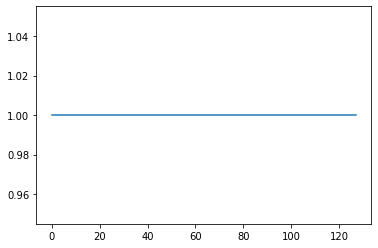

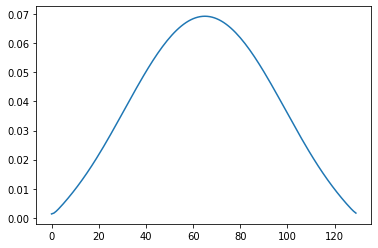





68


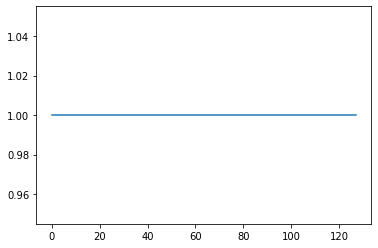

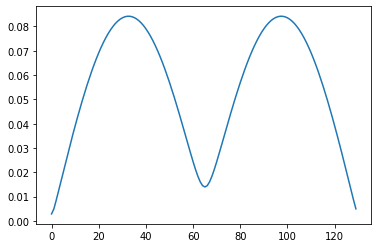





69


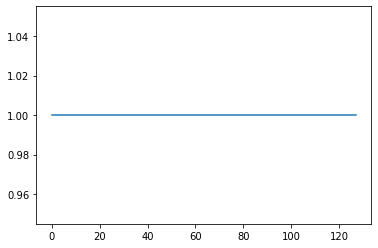

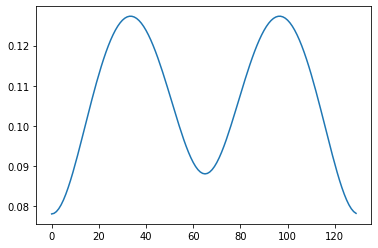





70


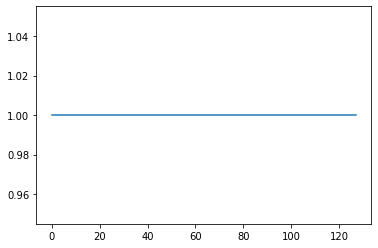

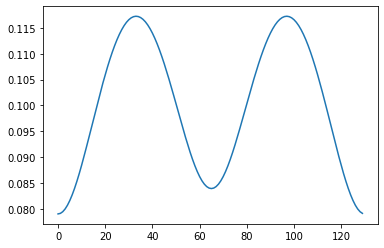





71


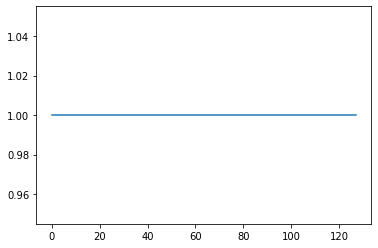

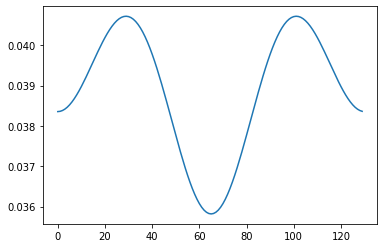





72


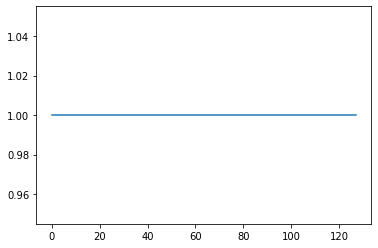

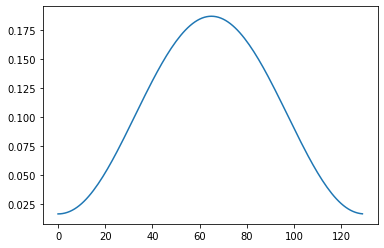





73


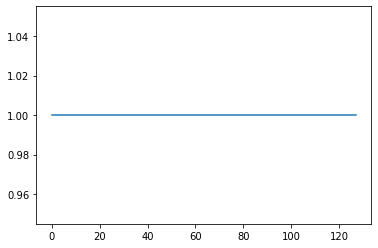

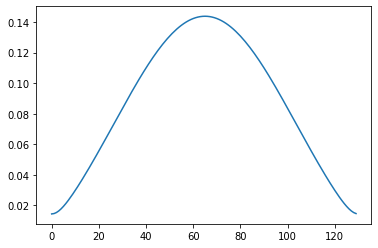





74


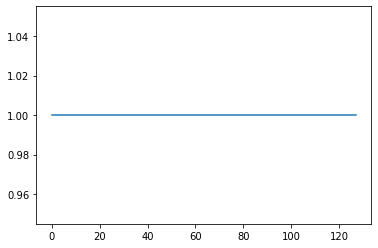

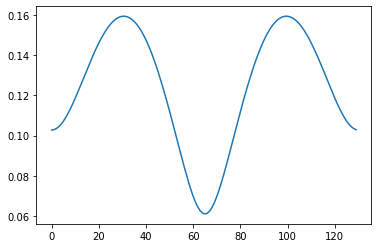





75


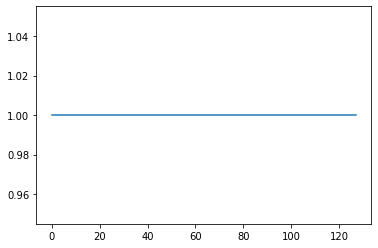

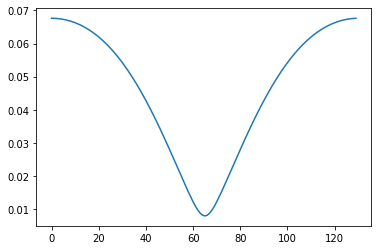





76


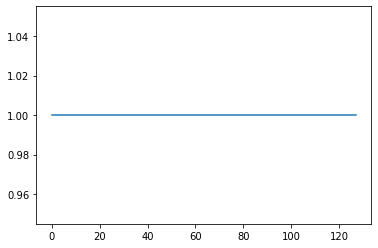

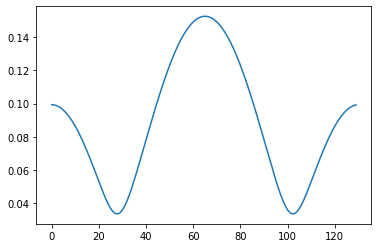





77


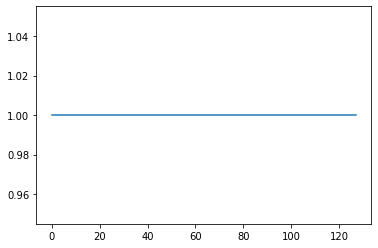

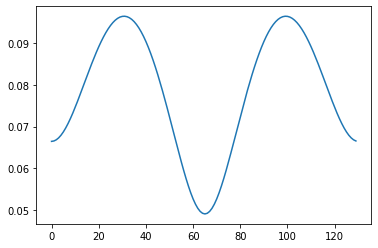





78


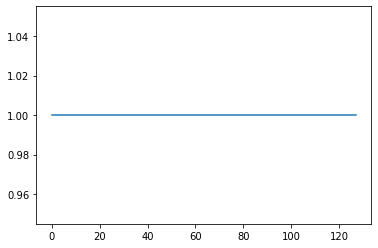

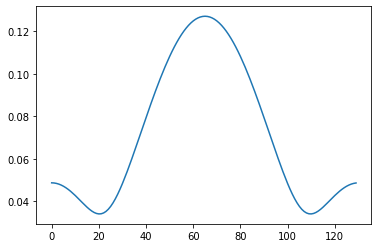





79


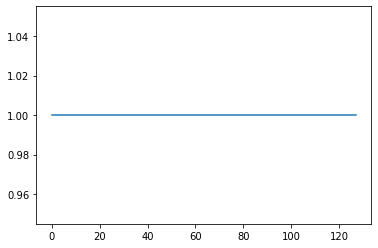

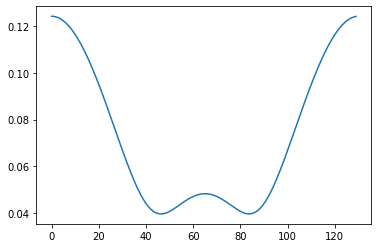





80


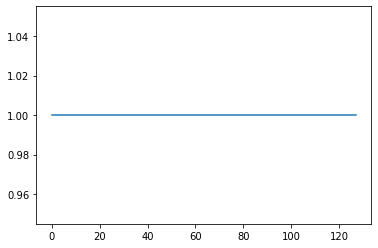

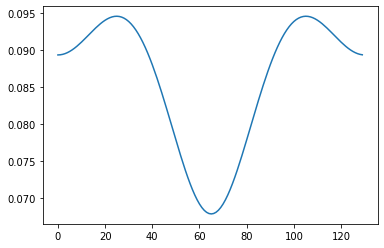





81


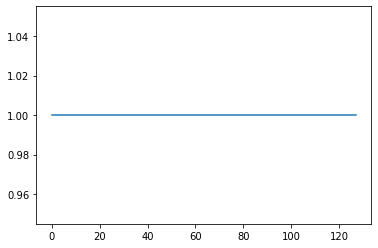

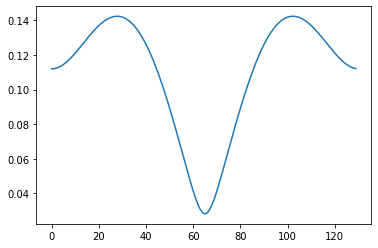





82


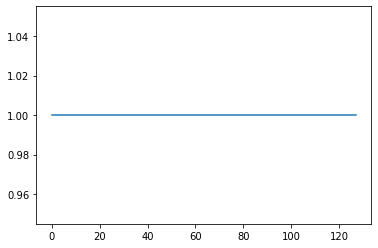

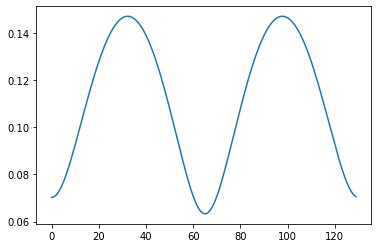





83


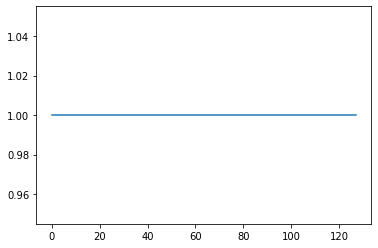

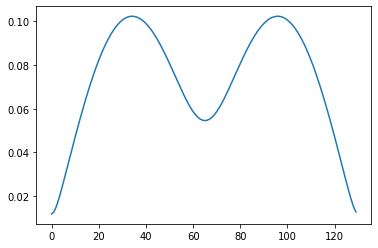





84


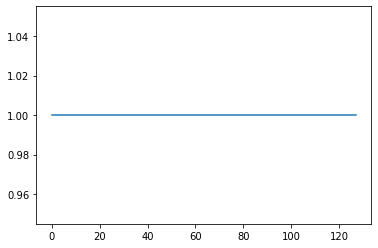

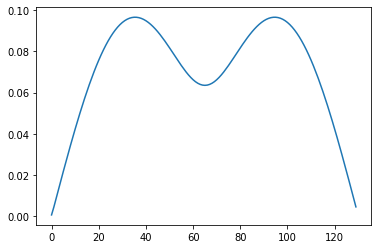





85


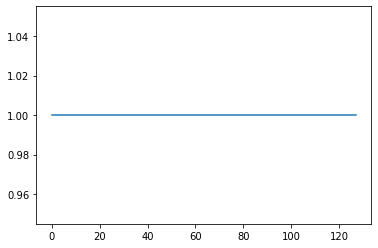

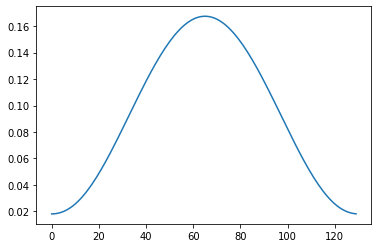





86


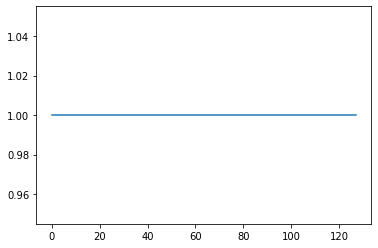

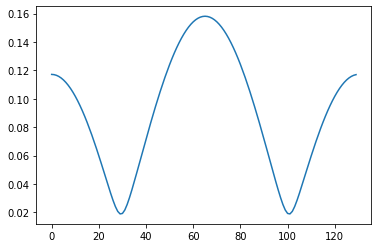





87


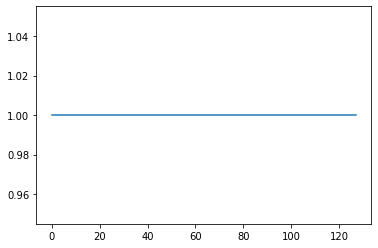

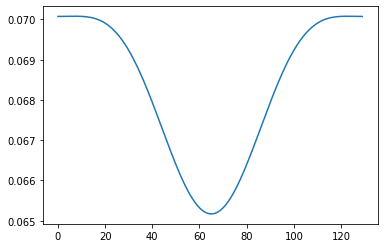





88


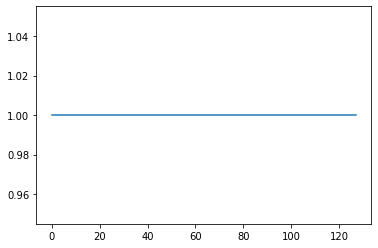

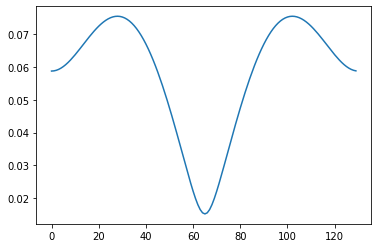





89


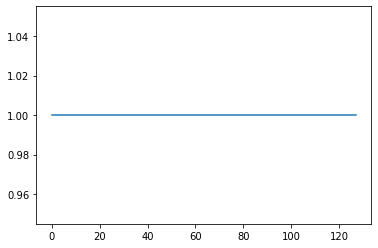

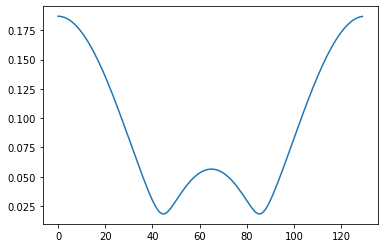





90


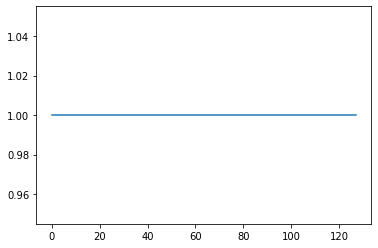

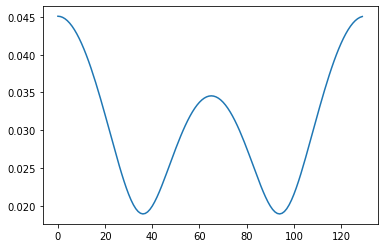





91


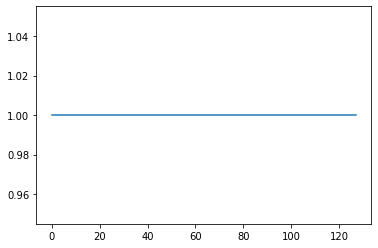

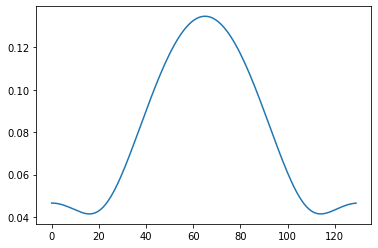





92


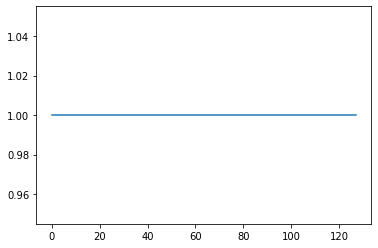

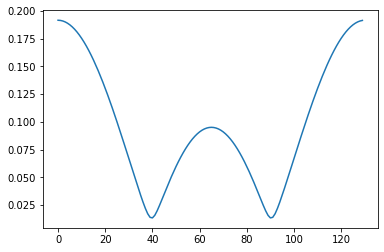





93


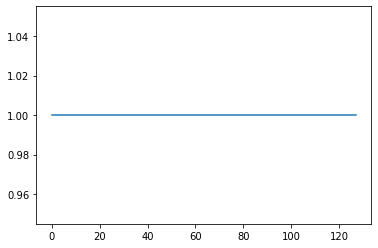

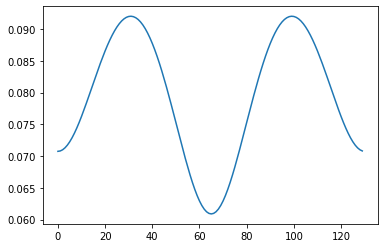





94


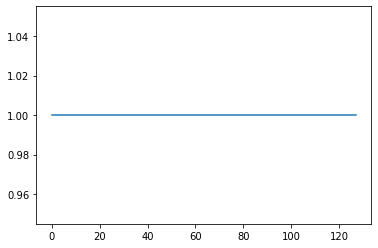

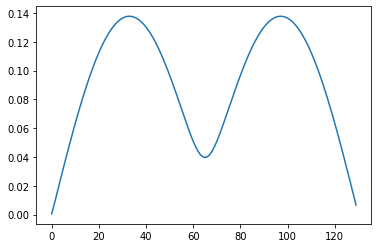





95


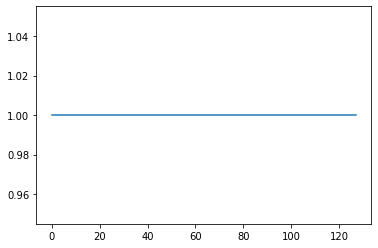

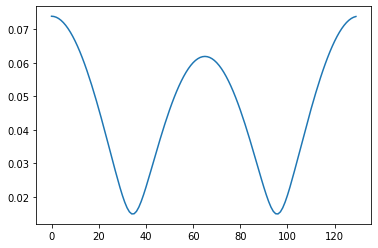





96


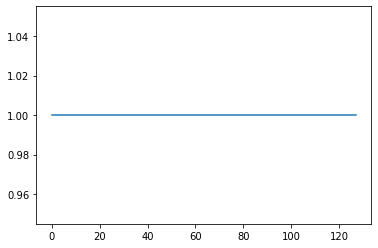

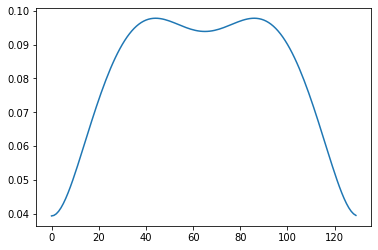





97


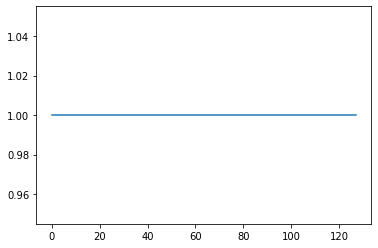

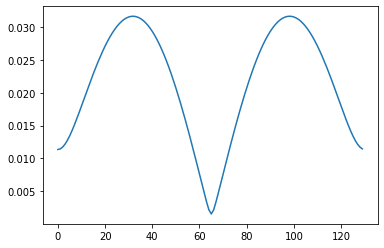





98


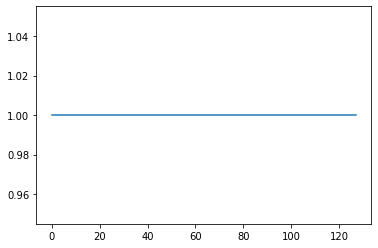

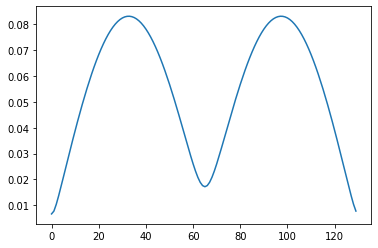





99


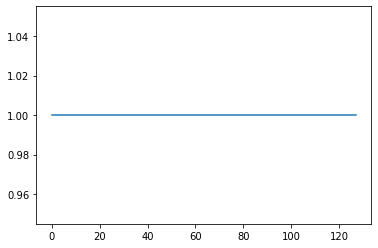

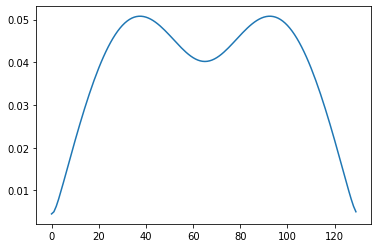





100


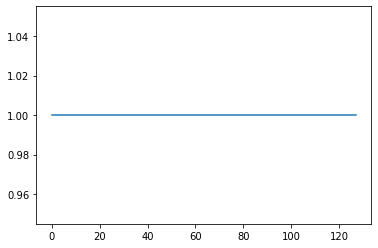

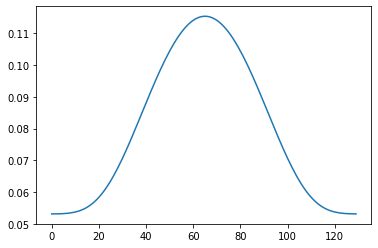





101


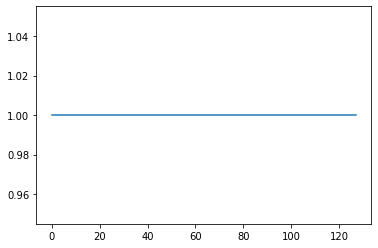

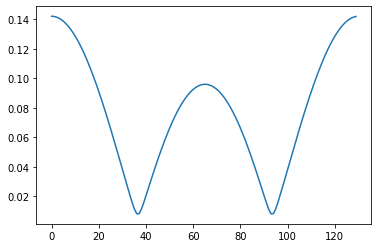





102


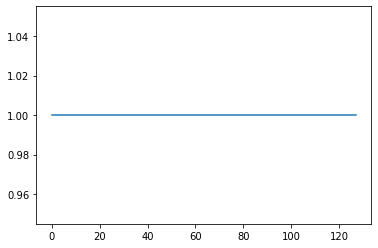

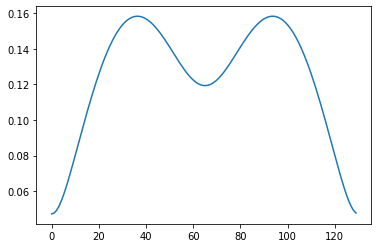





103


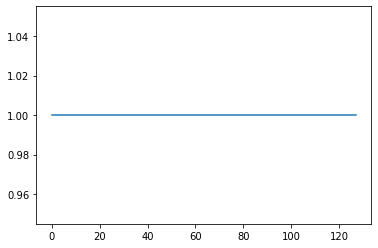

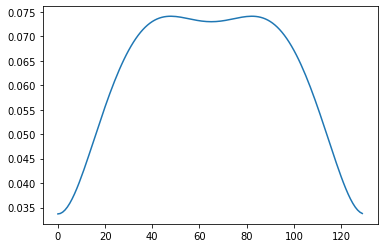





104


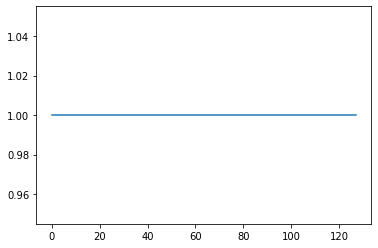

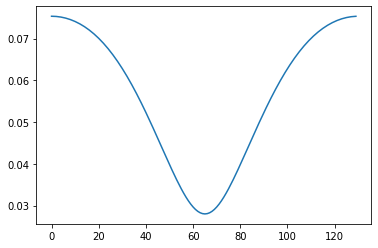





105


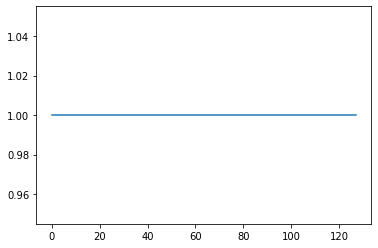

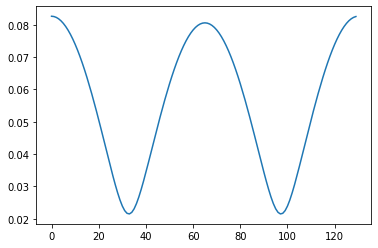





106


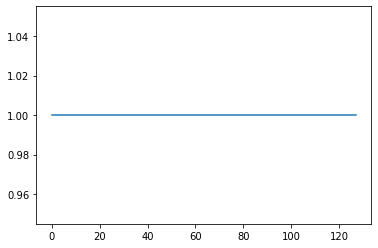

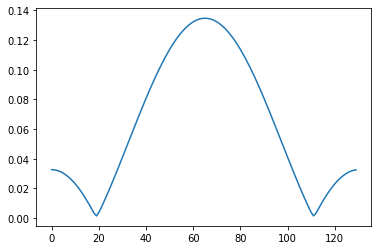





107


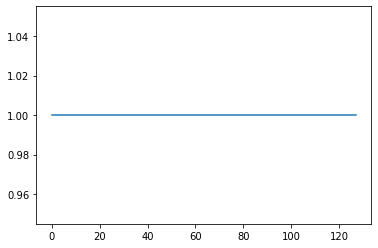

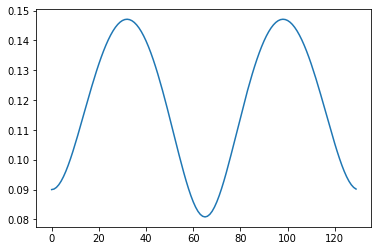





108


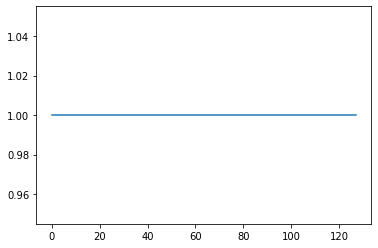

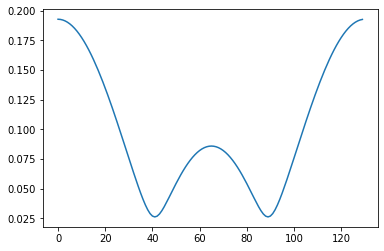





109


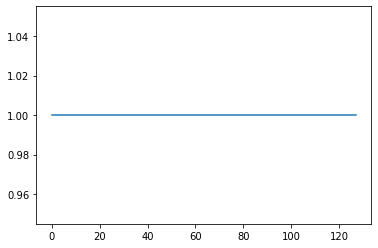

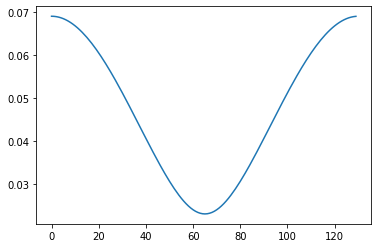





110


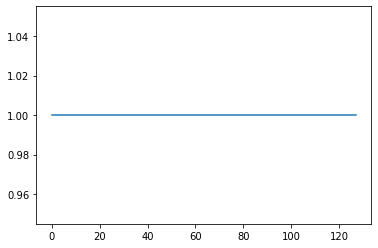

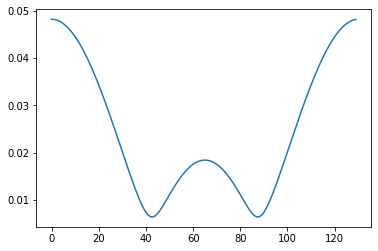





111


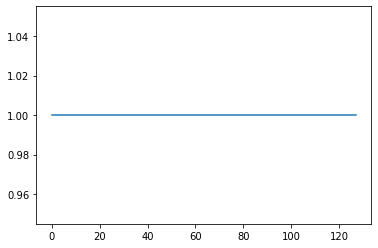

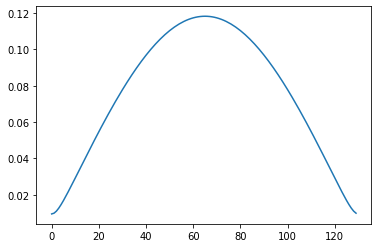





112


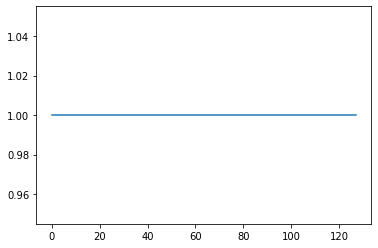

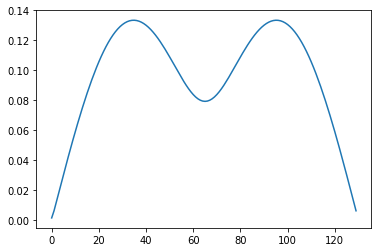





113


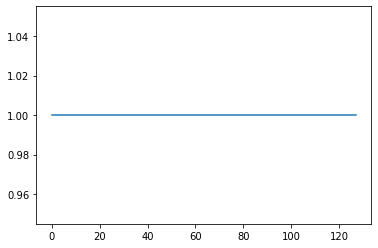

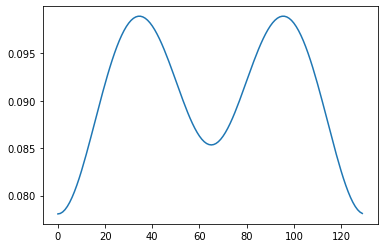





114


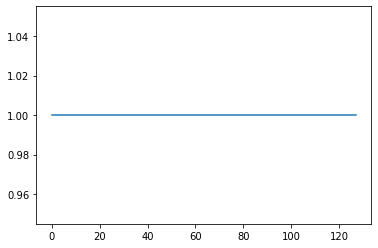

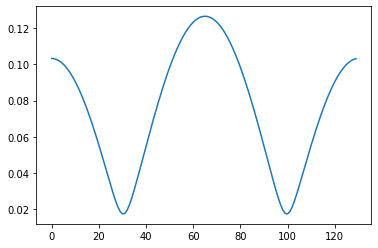





115


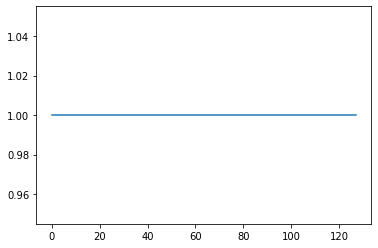

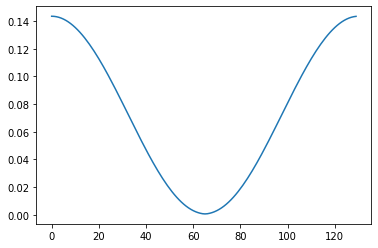





116


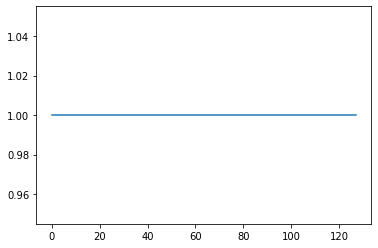

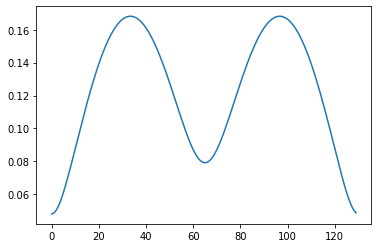





117


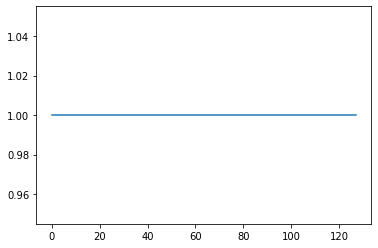

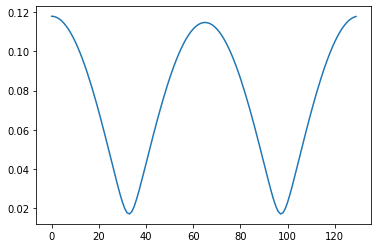





118


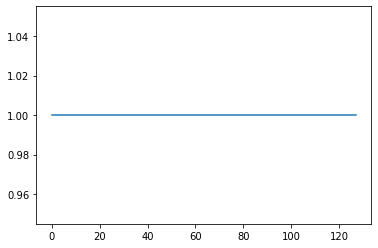

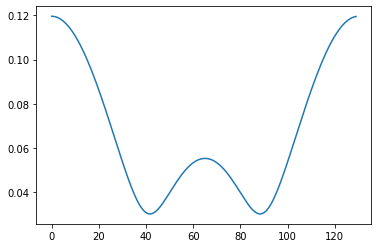





119


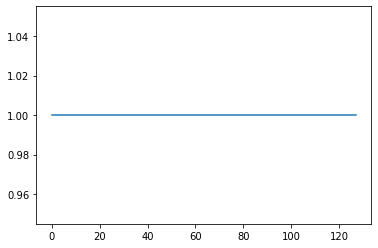

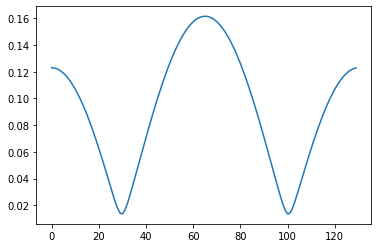





120


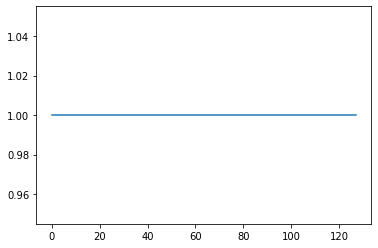

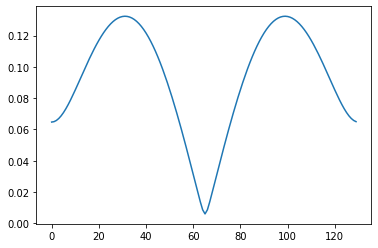





121


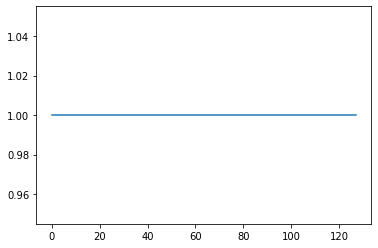

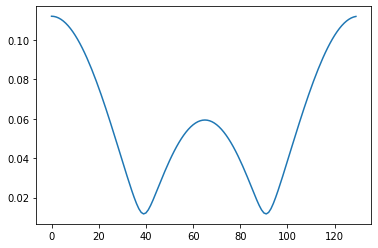





122


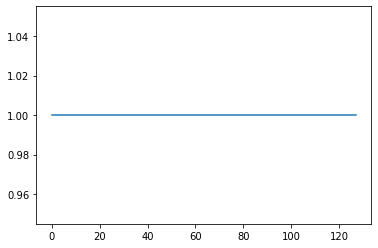

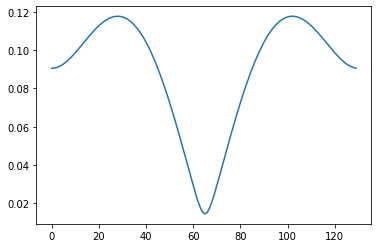





123


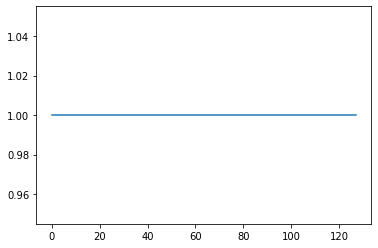

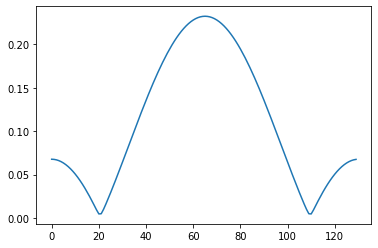





124


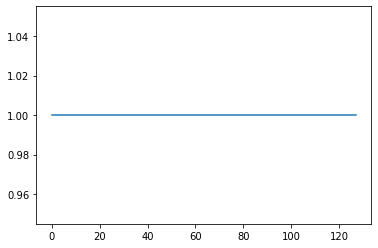

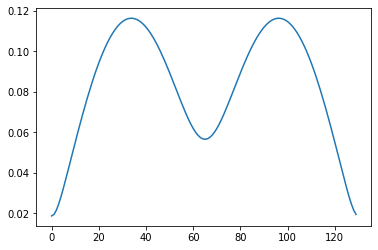





125


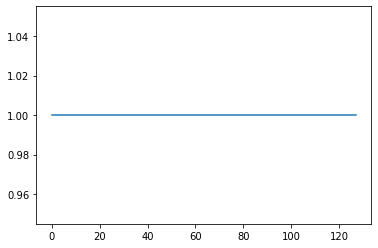

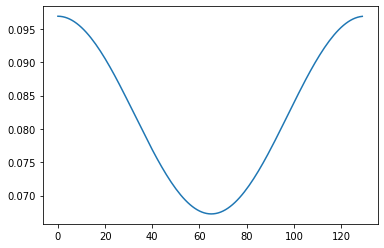





126


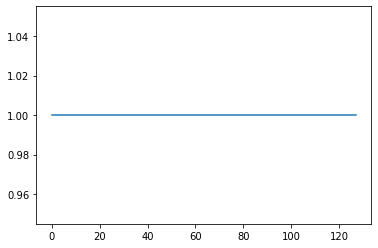

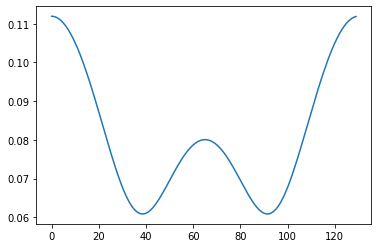





127


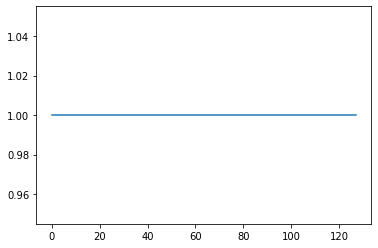

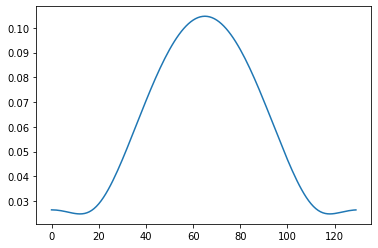





128


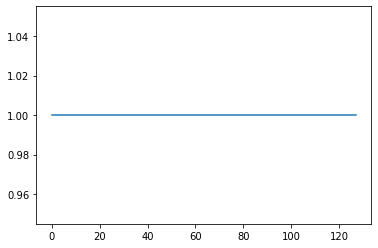

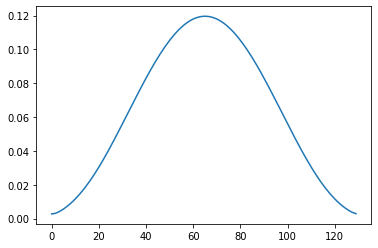





129


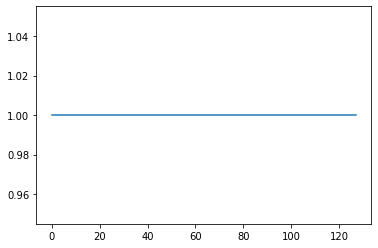

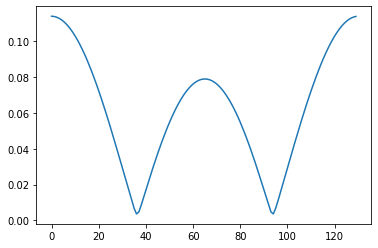





130


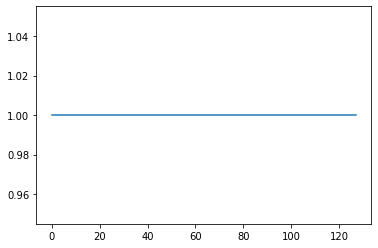

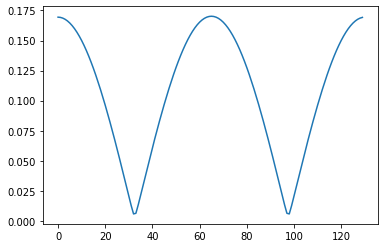





131


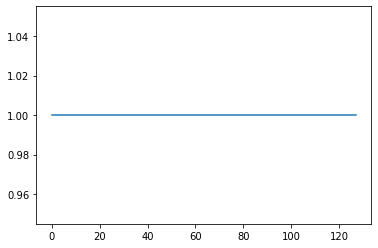

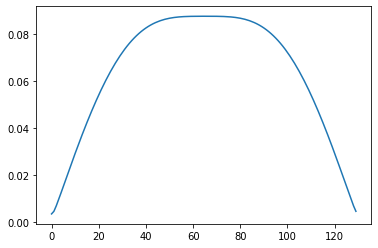





132


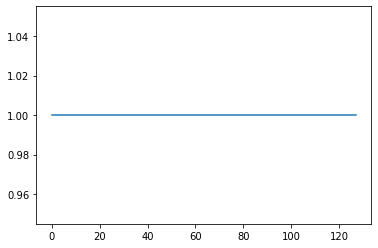

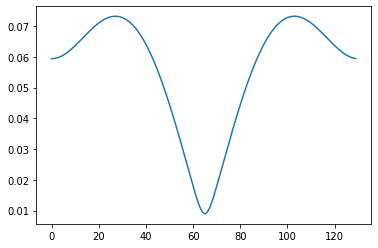





133


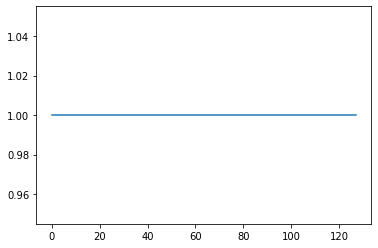

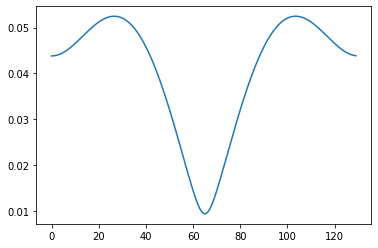





134


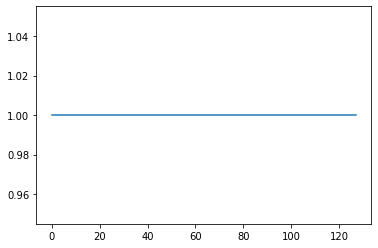

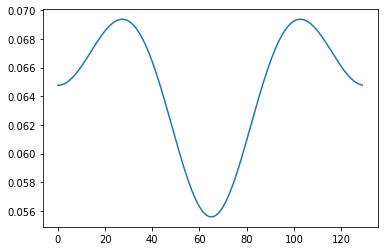





135


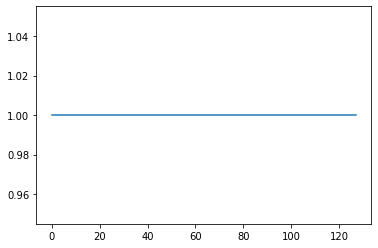

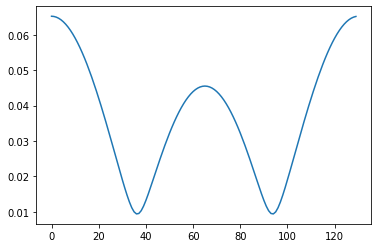





136


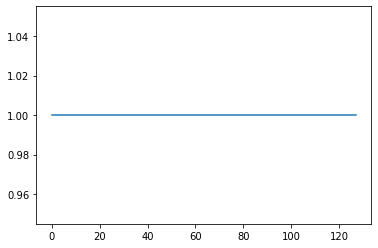

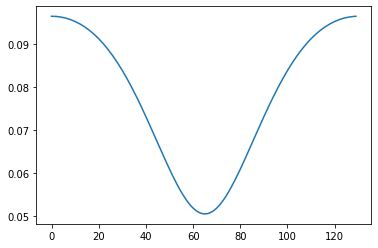





137


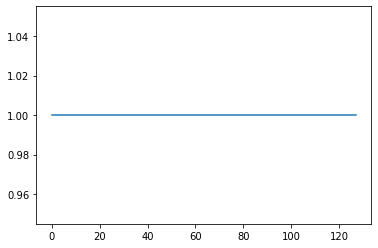

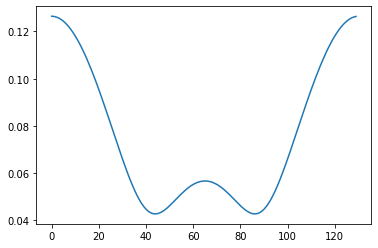





138


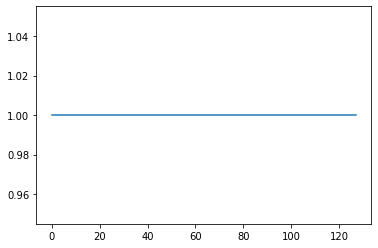

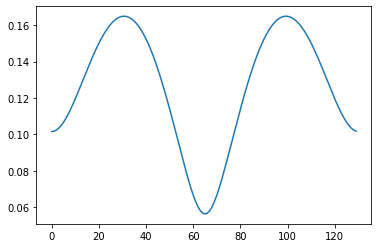





139


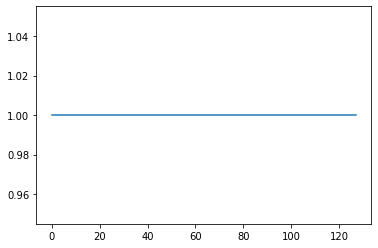

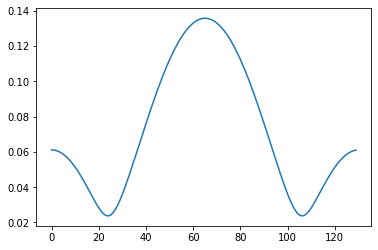





140


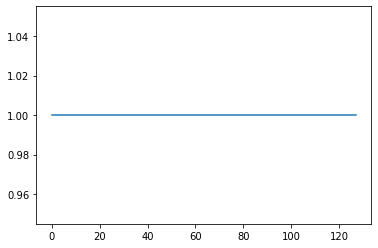

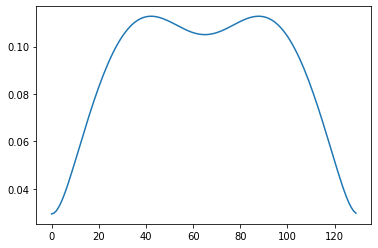





141


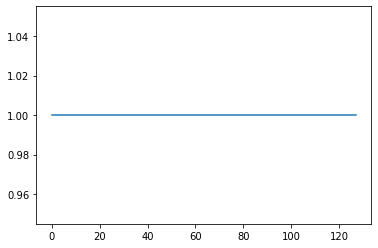

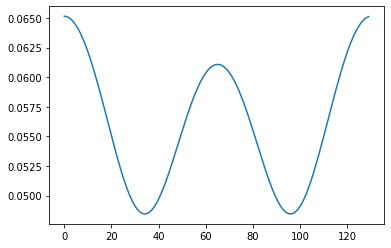





142


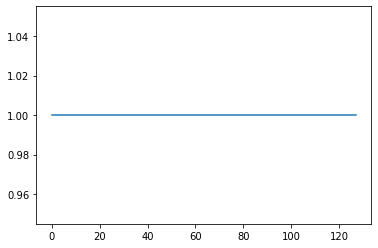

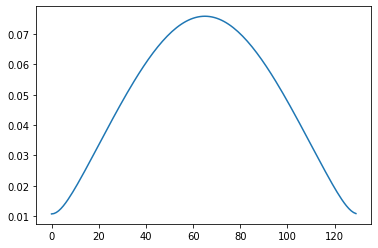





143


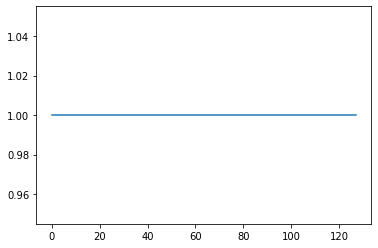

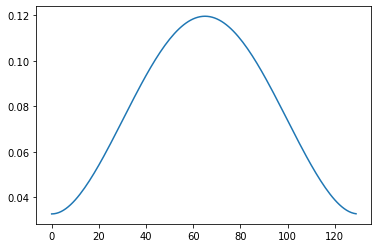





144


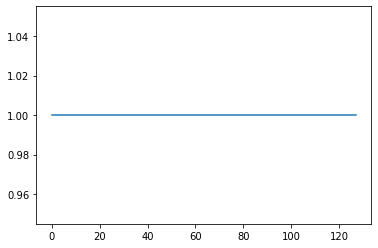

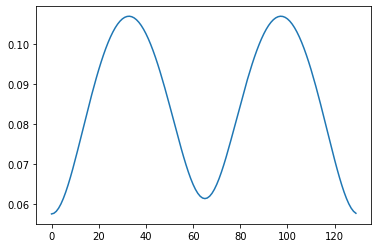





145


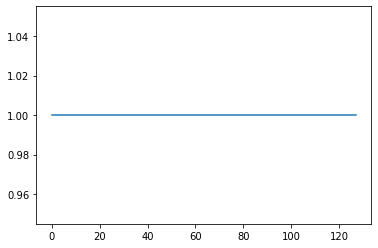

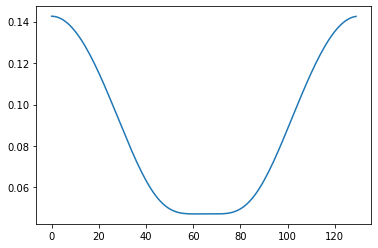





146


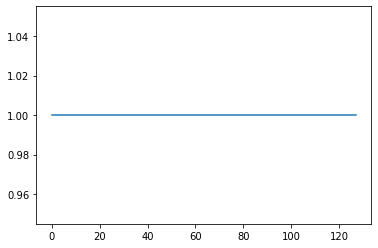

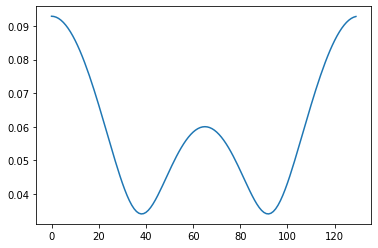





147


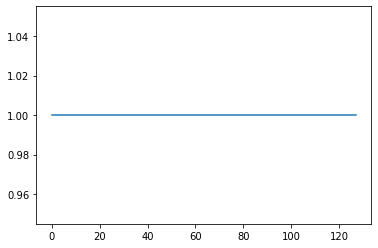

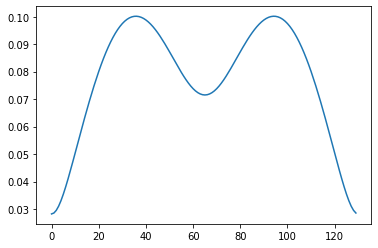





148


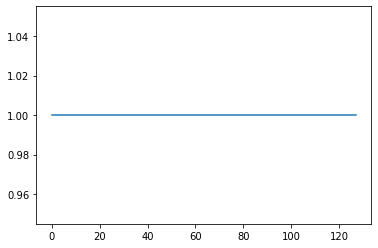

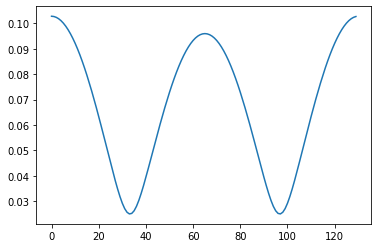





149


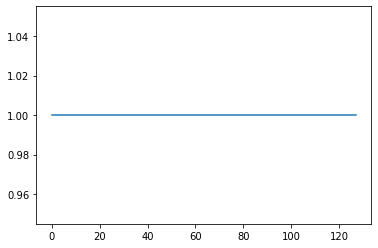

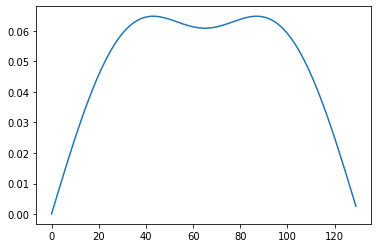





150


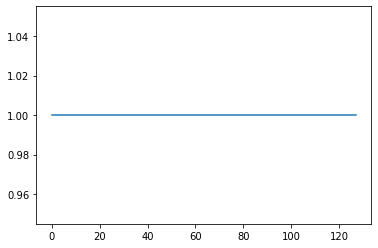

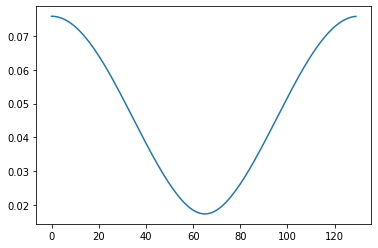





151


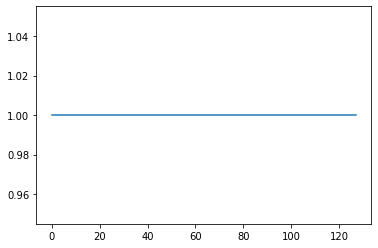

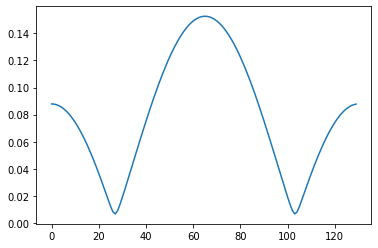





152


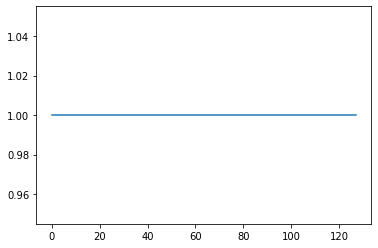

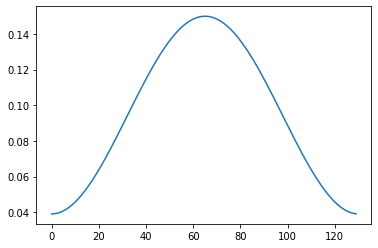





153


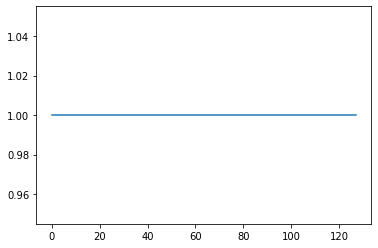

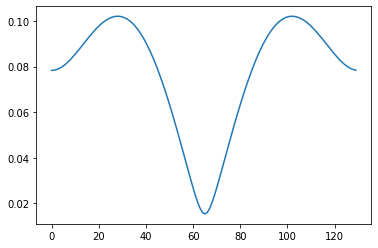





154


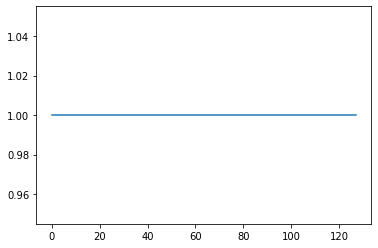

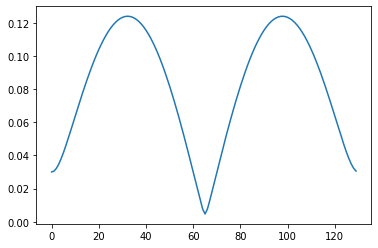





155


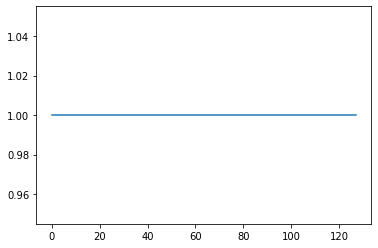

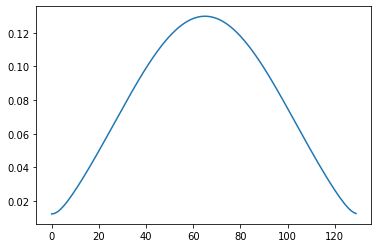





156


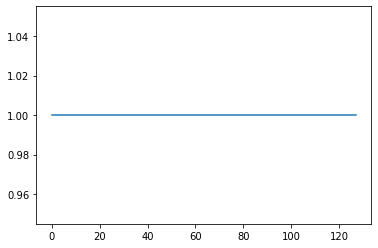

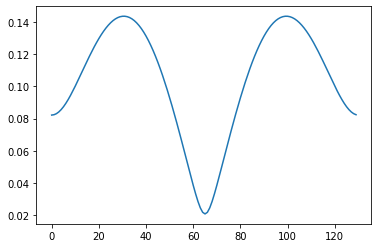





157


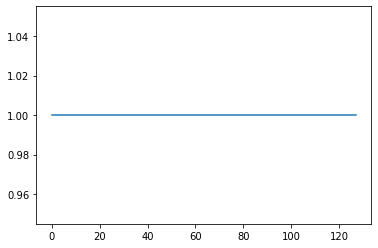

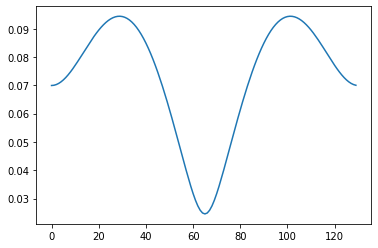





158


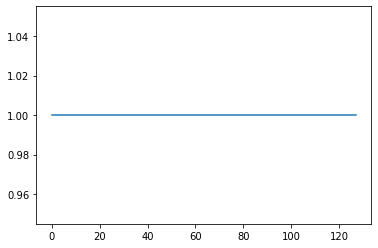

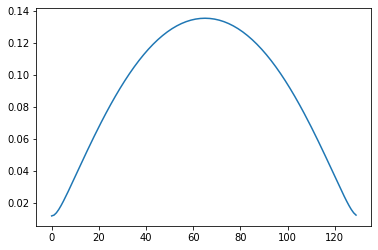





159


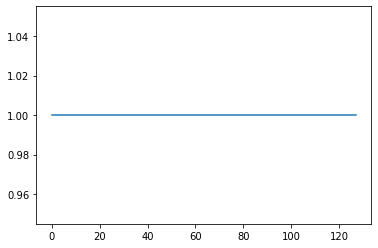

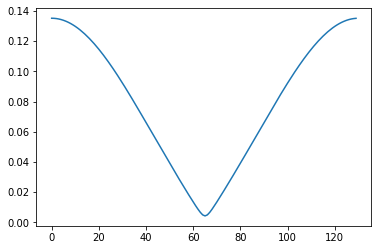





160


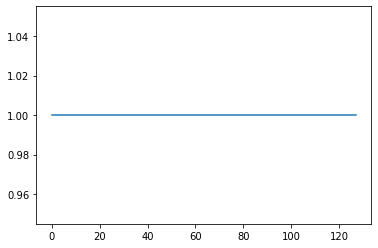

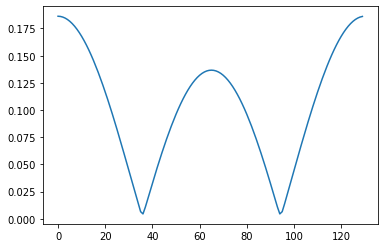





161


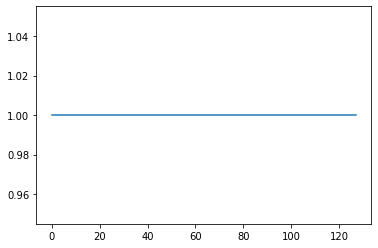

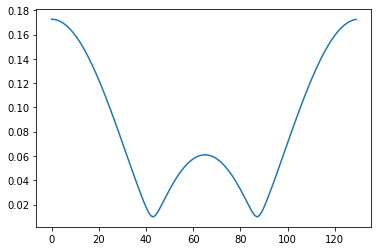





162


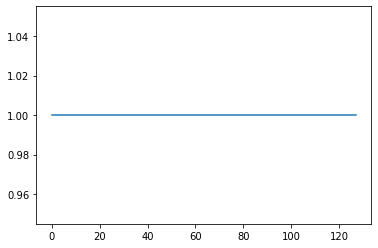

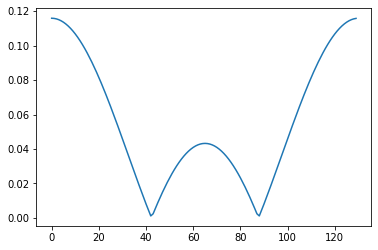





163


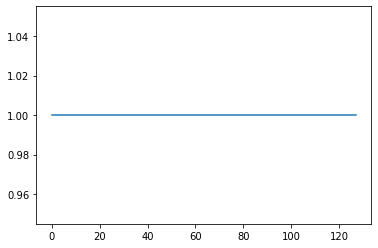

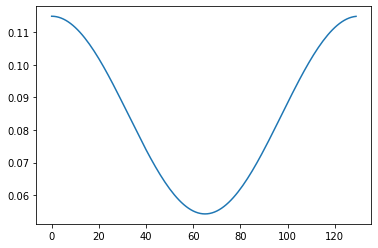





164


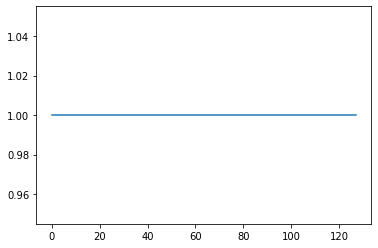

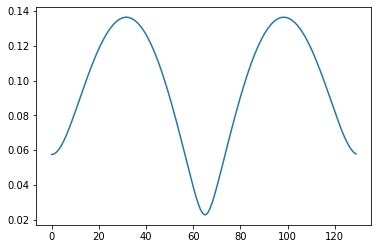





165


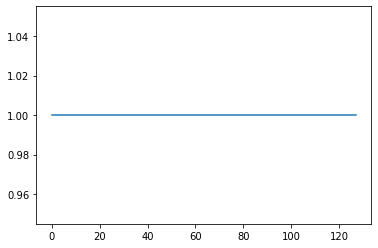

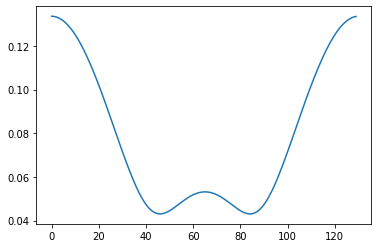





166


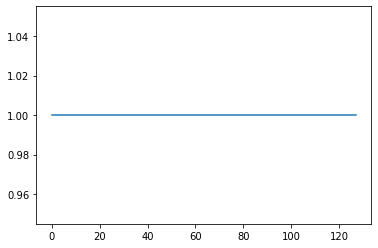

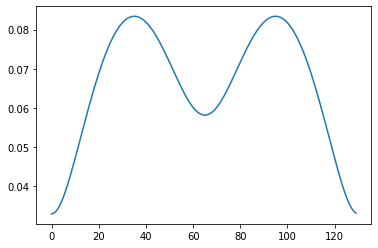





167


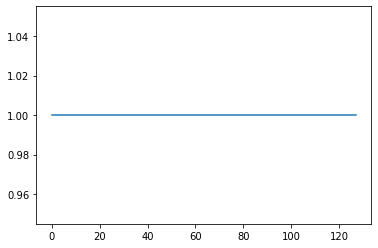

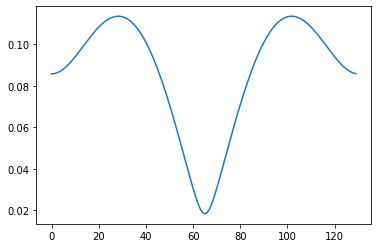





168


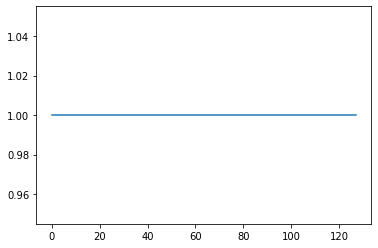

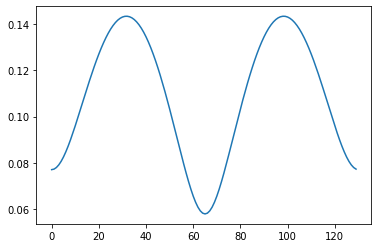





169


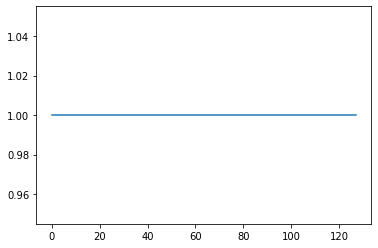

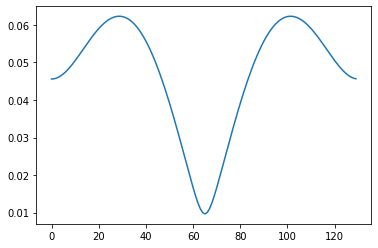





170


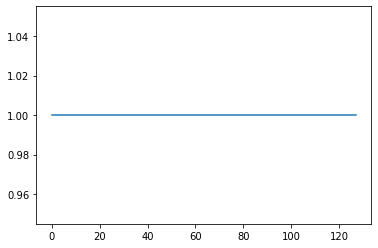

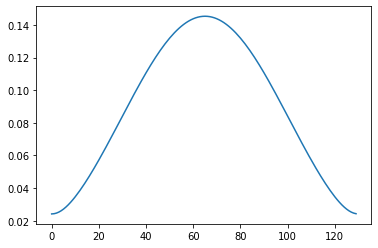





171


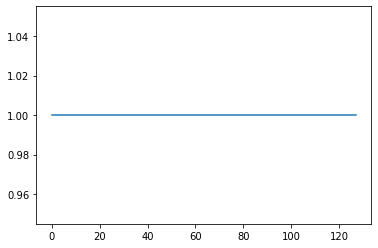

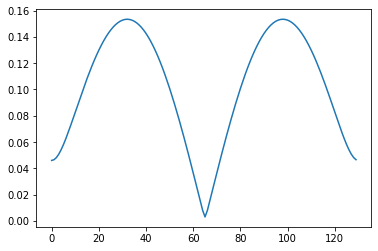





172


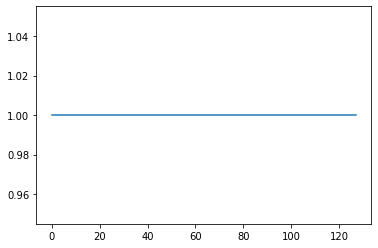

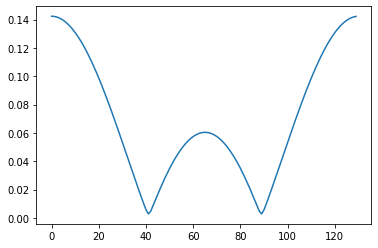





173


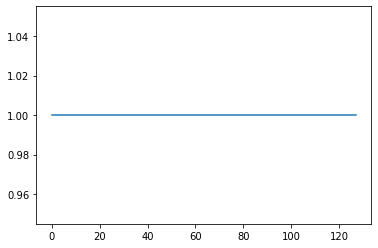

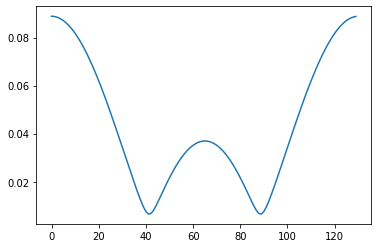





174


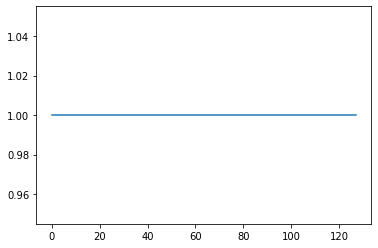

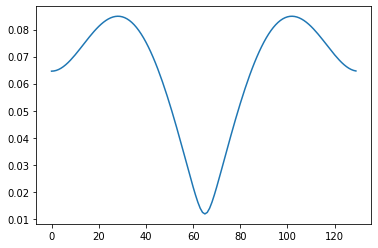





175


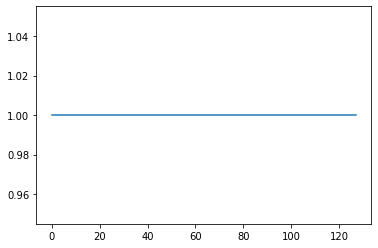

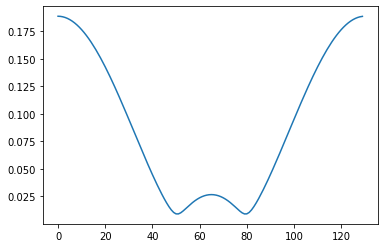





176


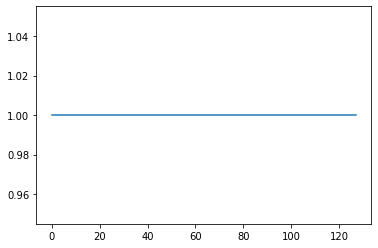

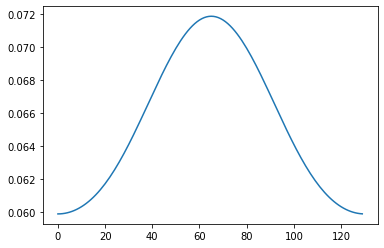





177


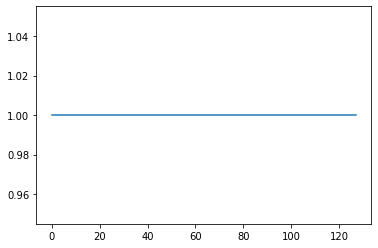

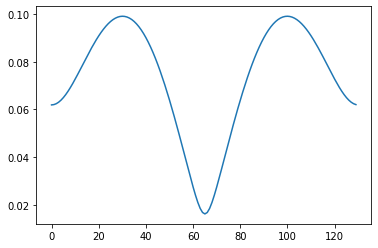





178


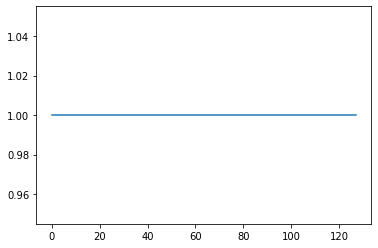

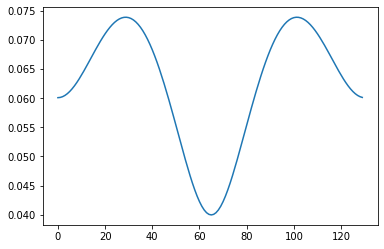





179


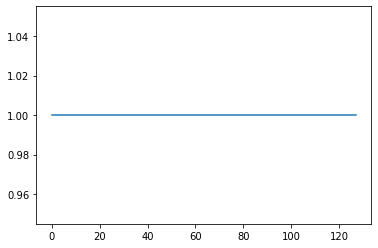

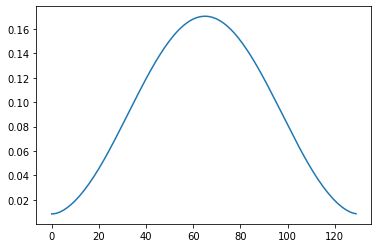





180


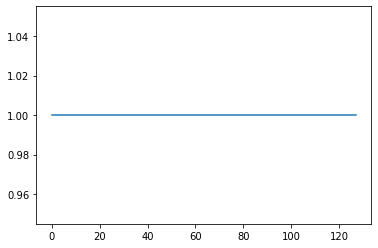

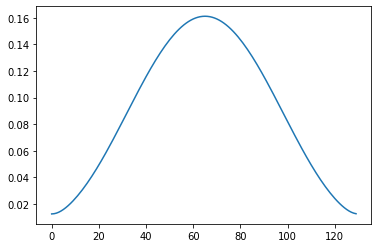





181


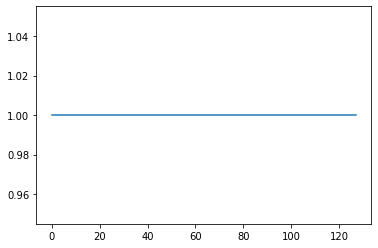

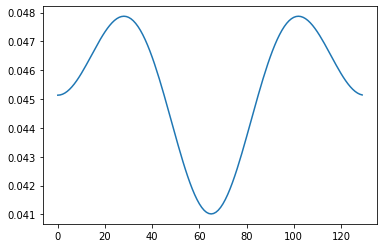





182


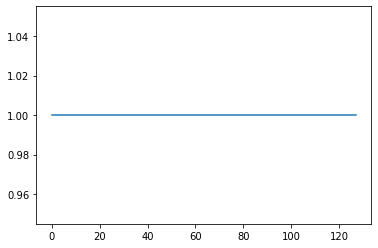

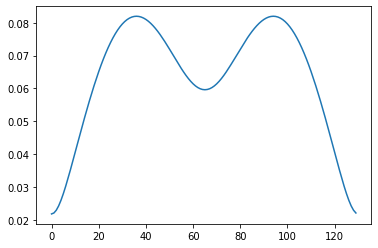





183


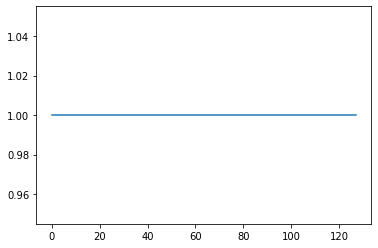

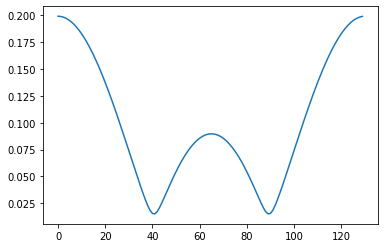





184


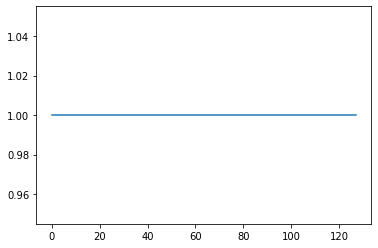

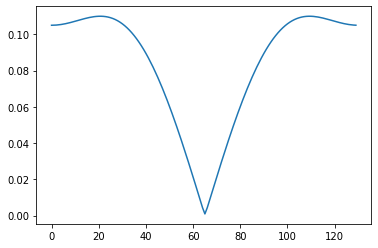





185


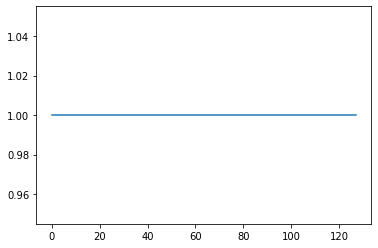

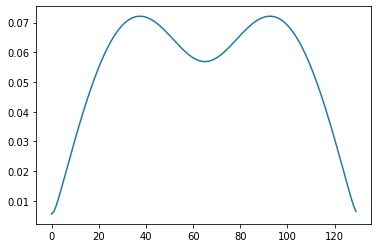





186


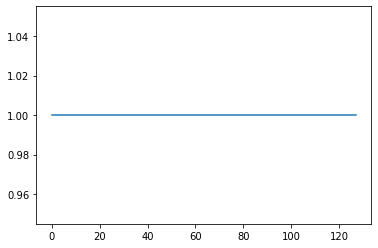

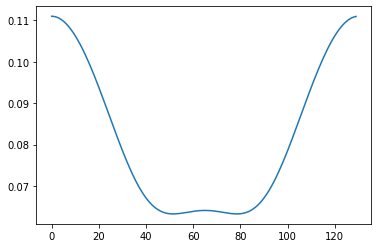





187


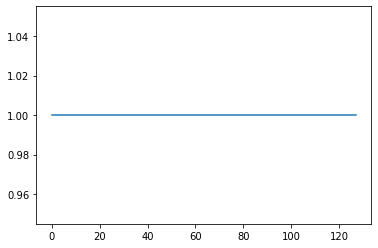

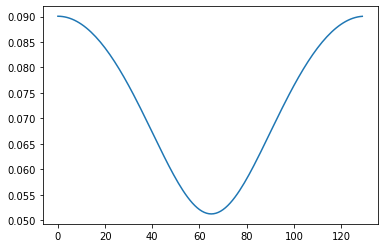





188


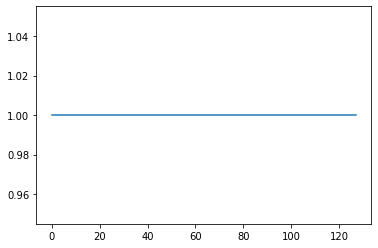

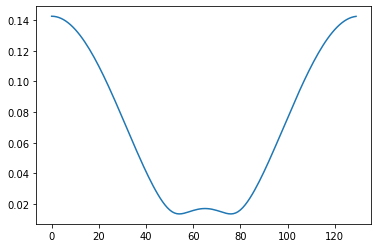





189


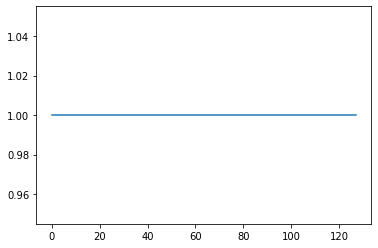

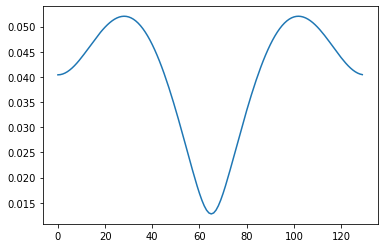





190


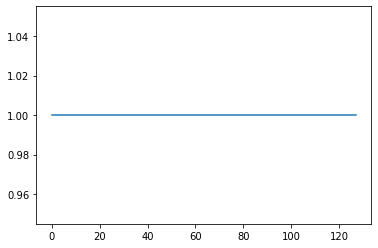

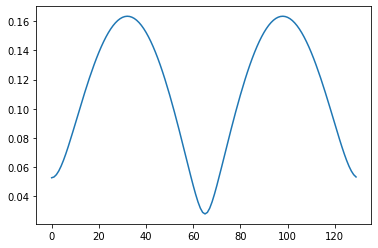





191


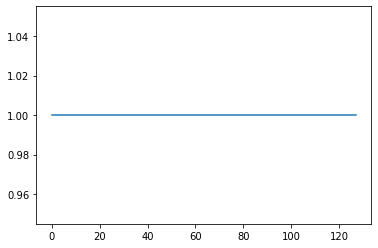

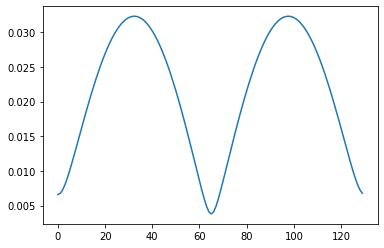





192


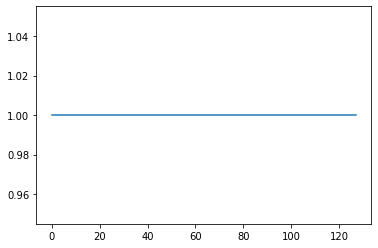

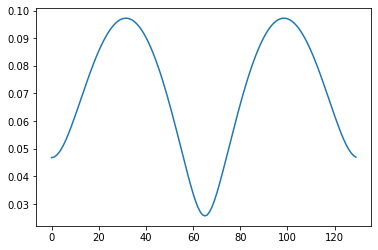





193


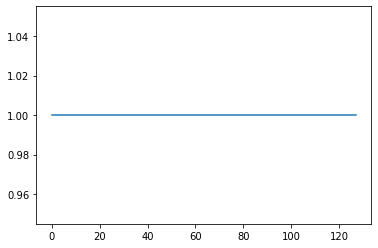

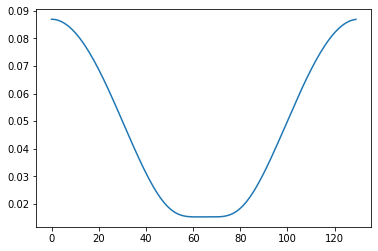





194


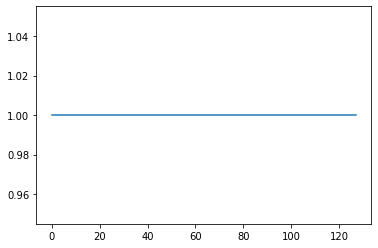

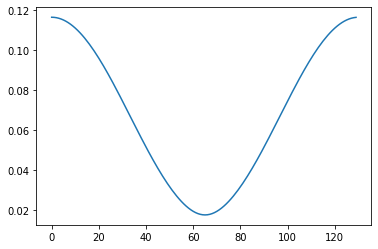





195


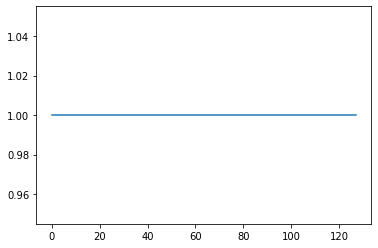

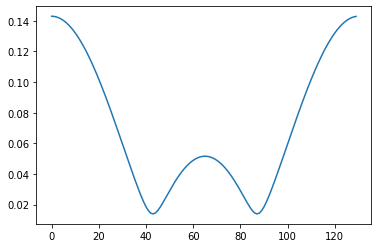





196


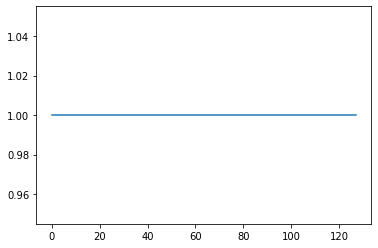

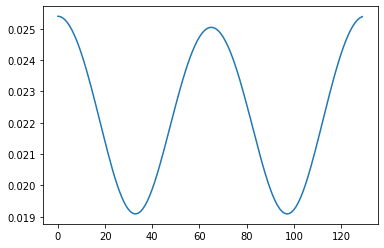





197


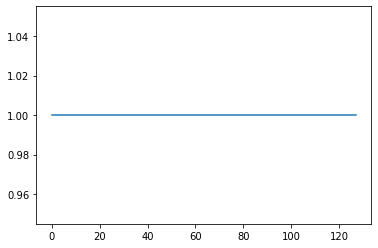

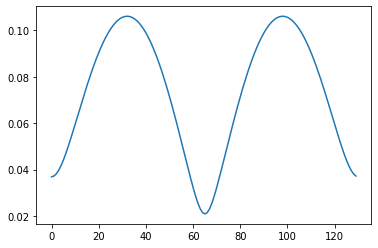





198


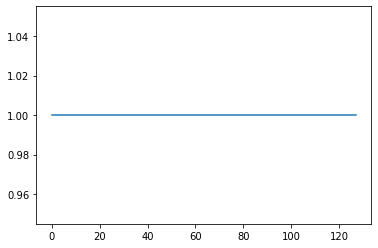

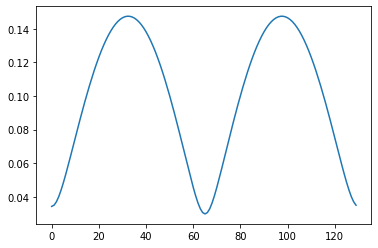





199


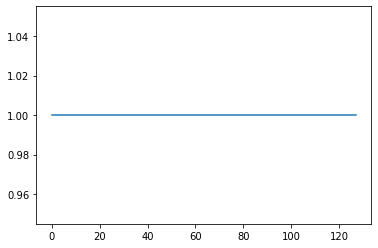

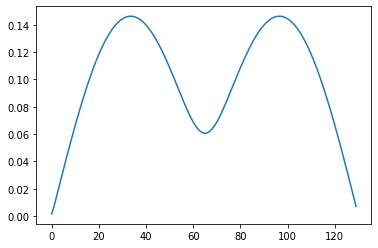





200


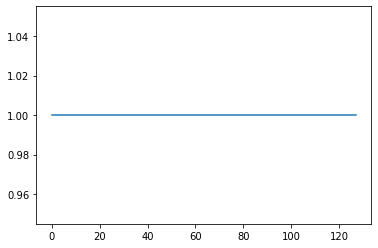

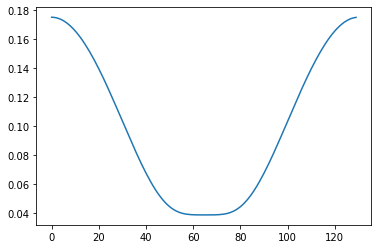





201


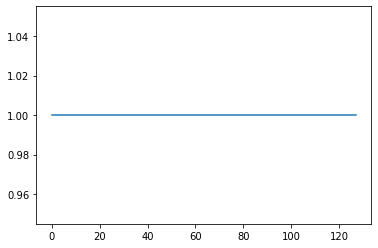

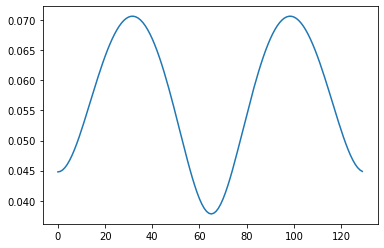





202


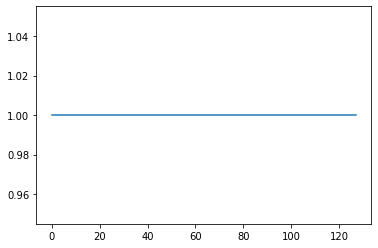

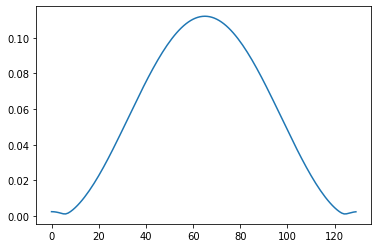





203


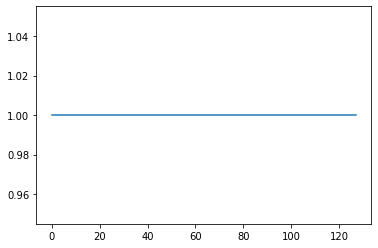

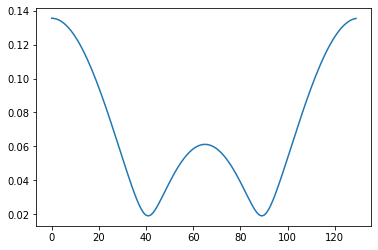





204


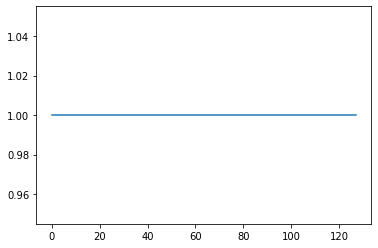

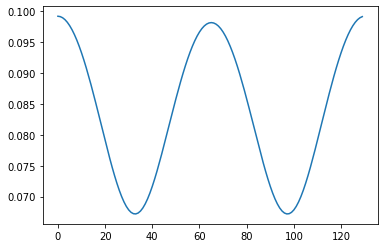





205


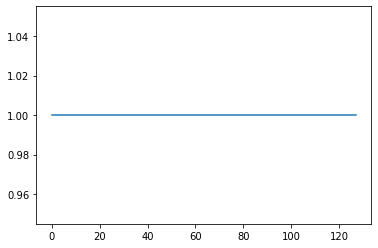

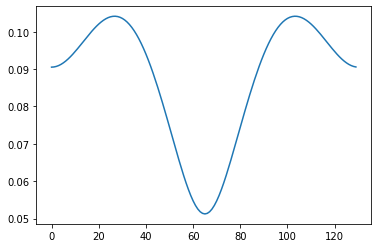





206


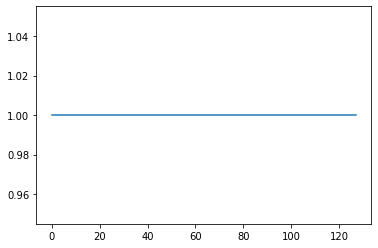

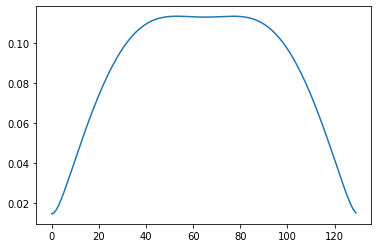





207


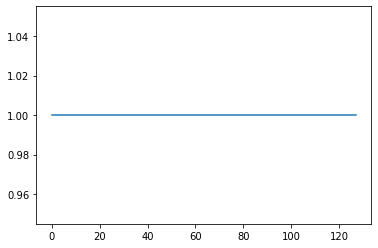

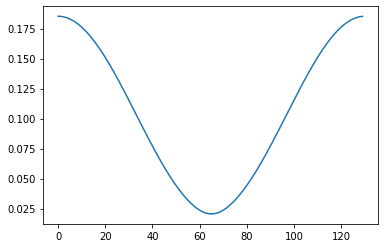





208


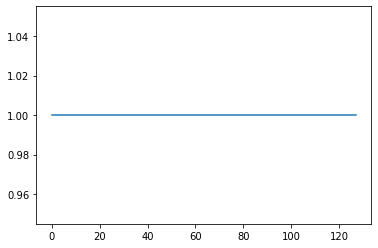

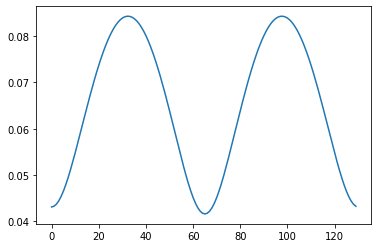





209


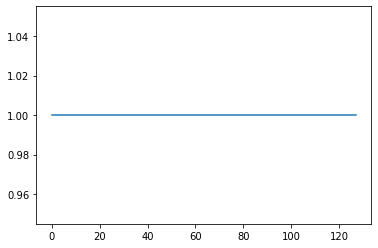

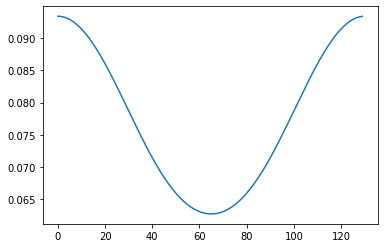





210


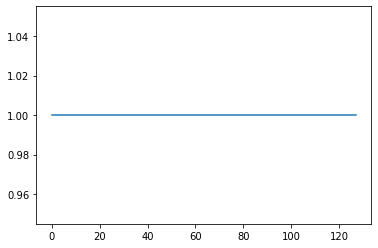

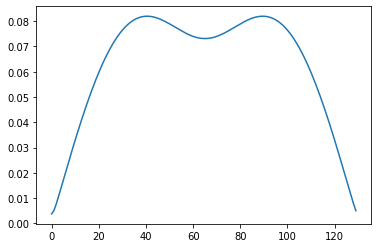





211


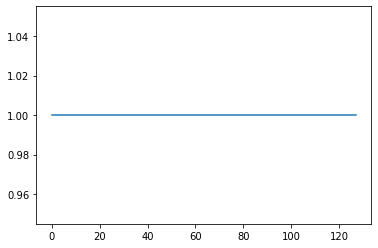

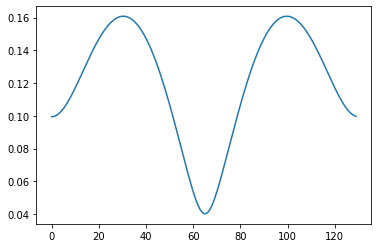





212


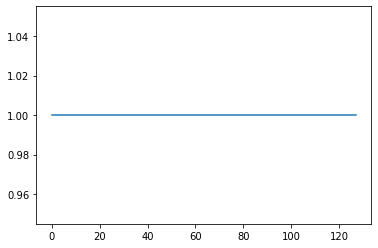

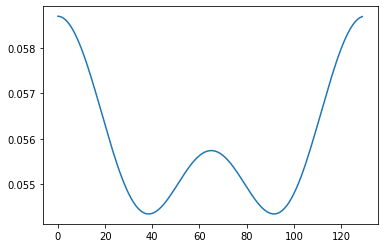





213


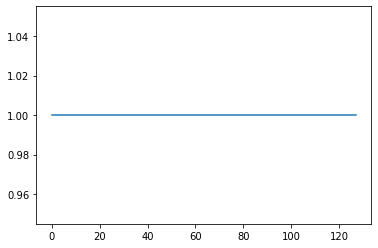

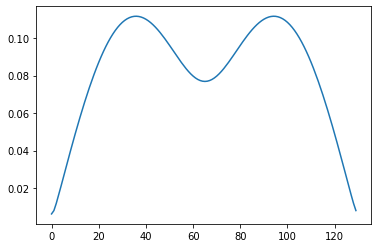





214


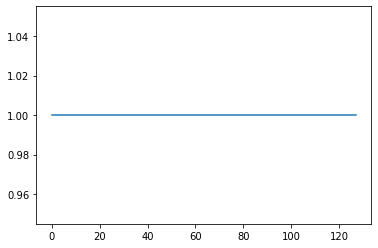

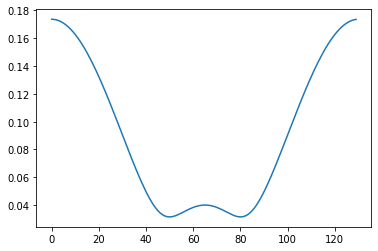





215


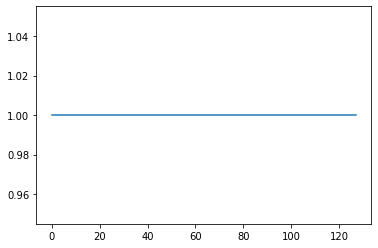

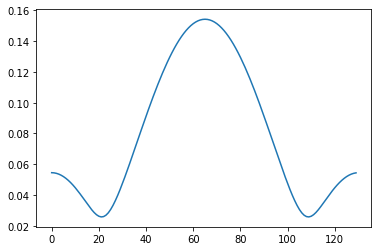





216


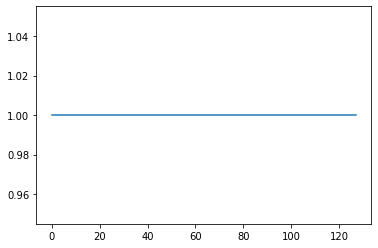

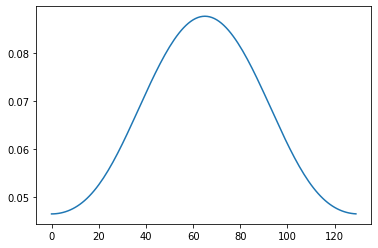





217


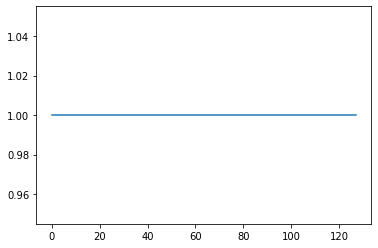

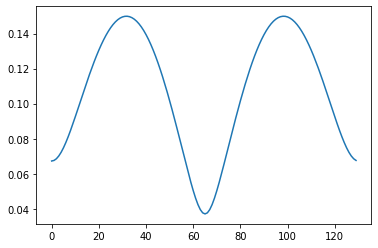





218


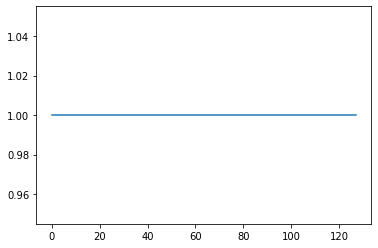

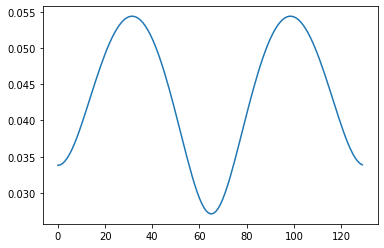





219


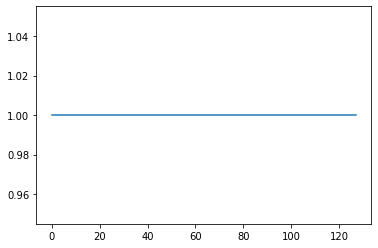

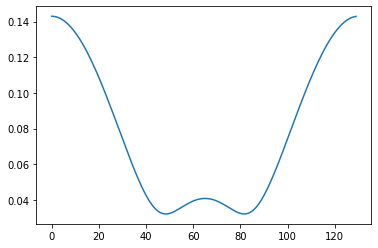





220


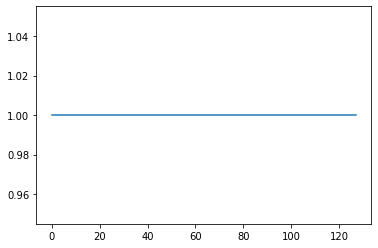

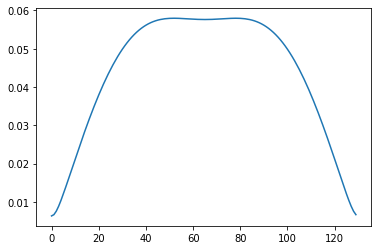





221


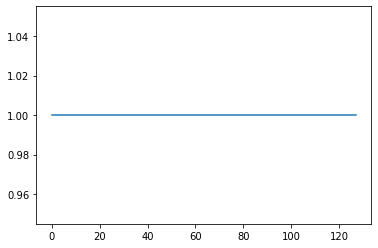

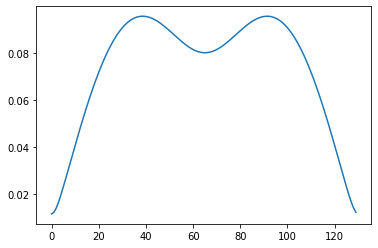





222


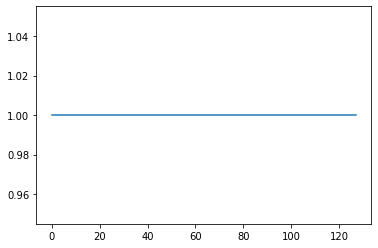

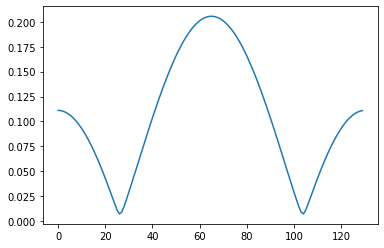





223


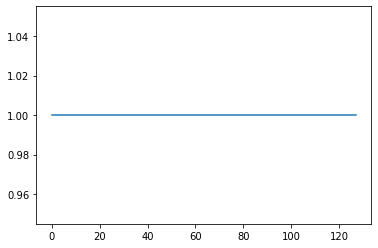

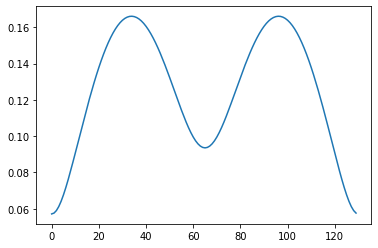





224


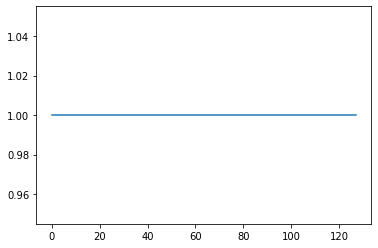

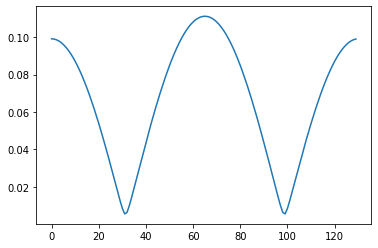





225


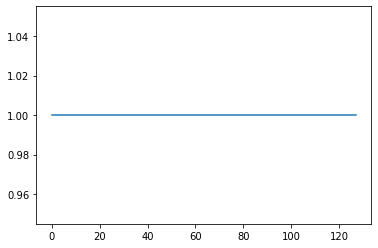

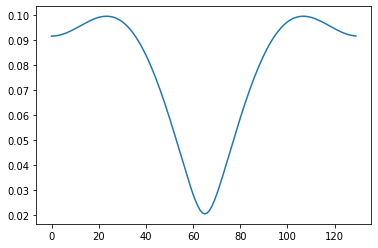





226


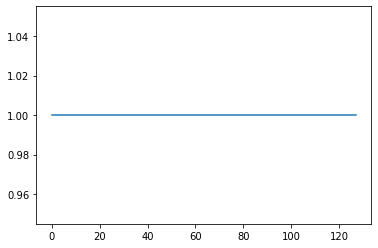

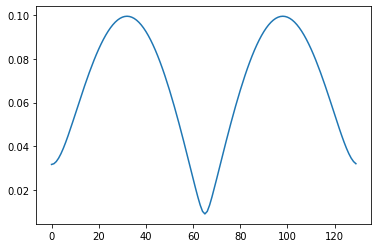





227


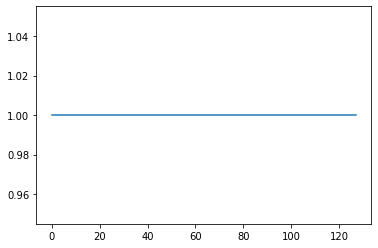

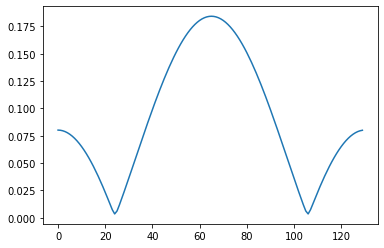





228


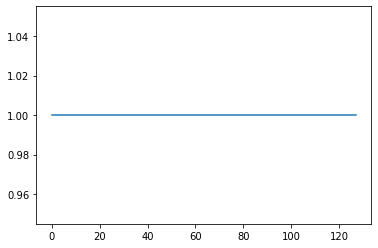

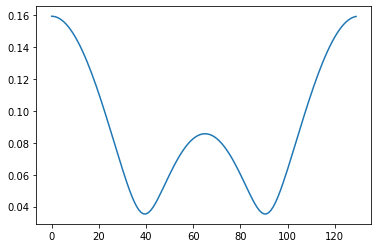





229


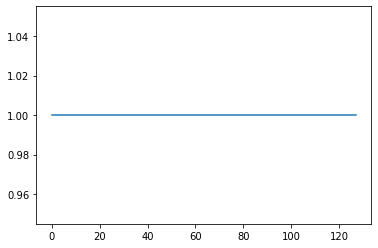

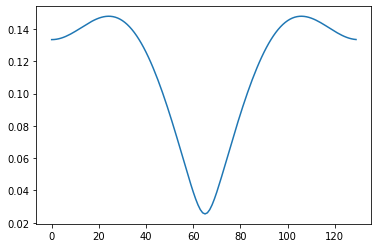





230


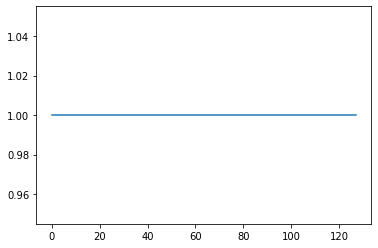

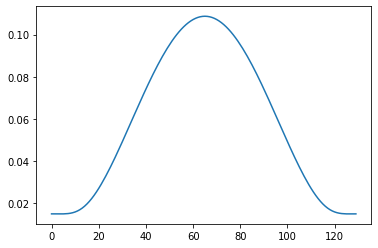





231


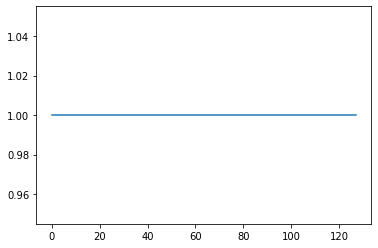

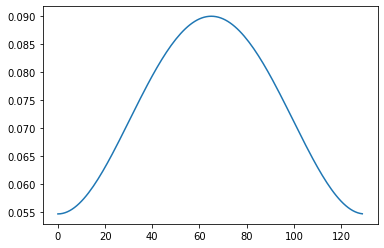





232


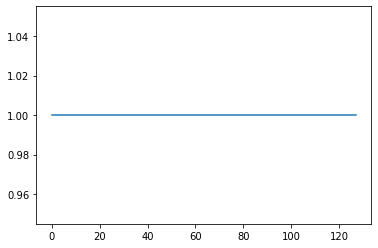

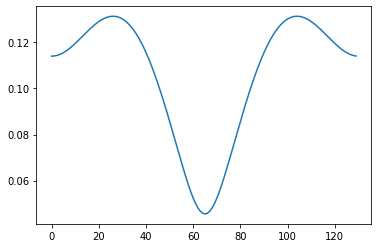





233


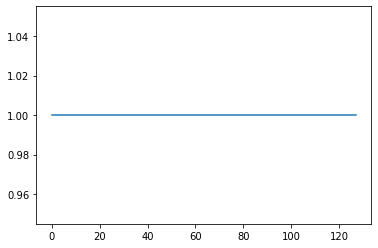

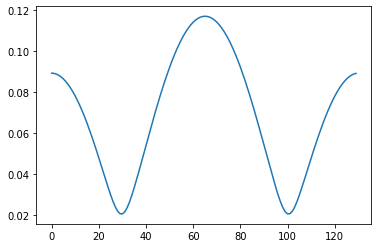





234


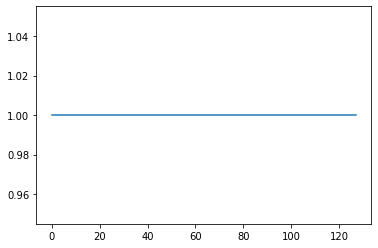

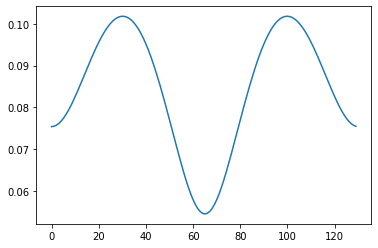





235


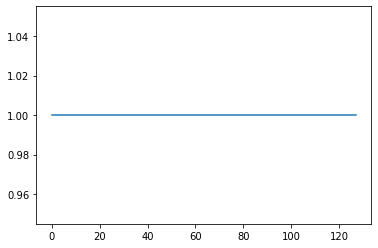

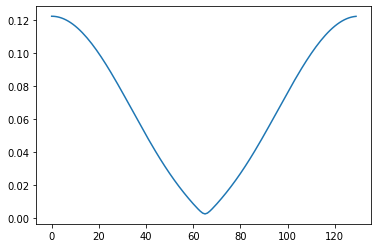





236


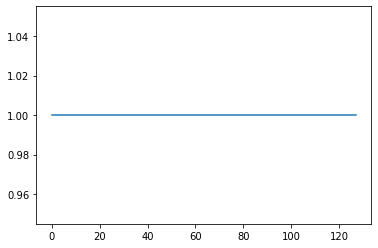

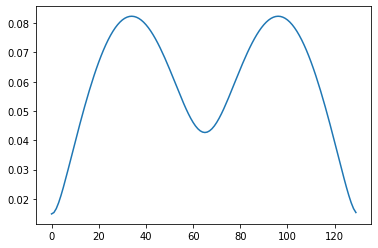





237


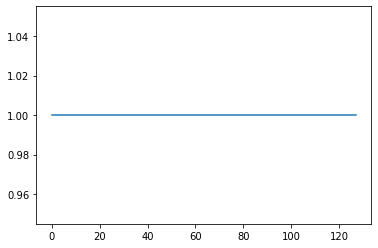

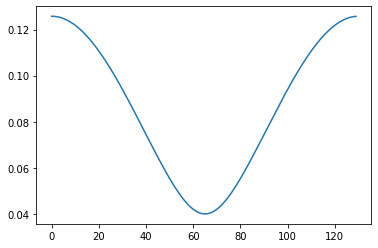





238


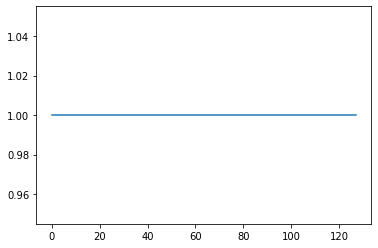

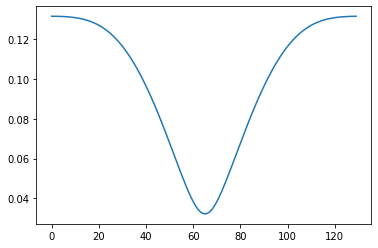





239


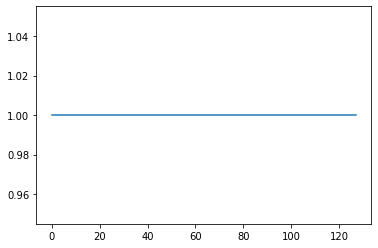

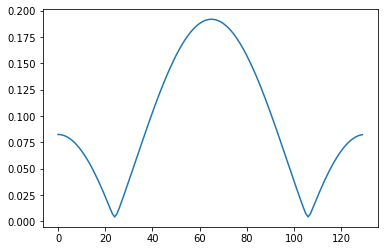





240


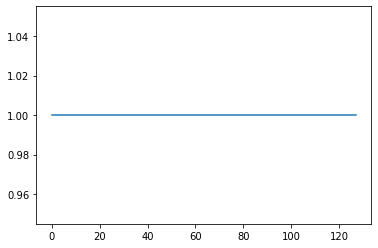

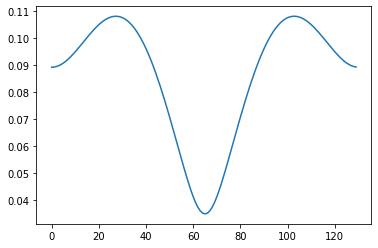





241


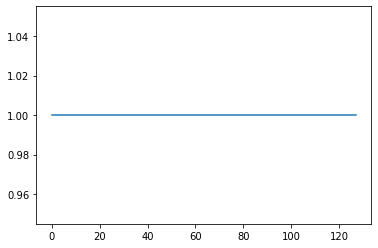

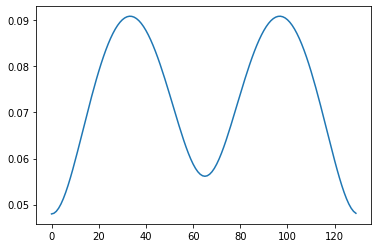





242


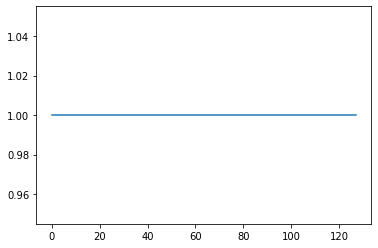

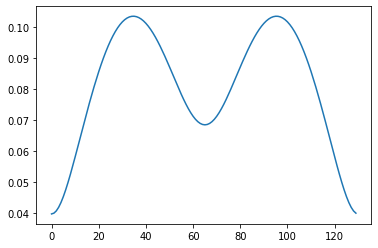





243


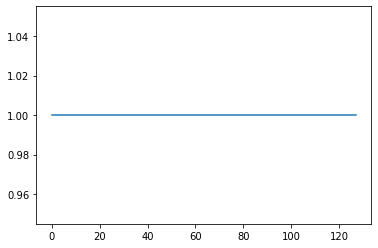

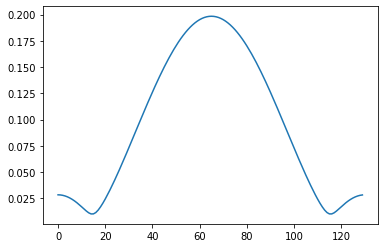





244


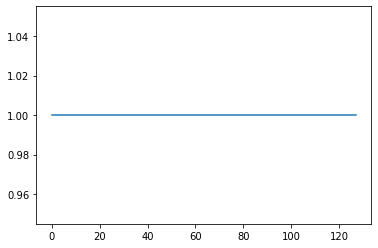

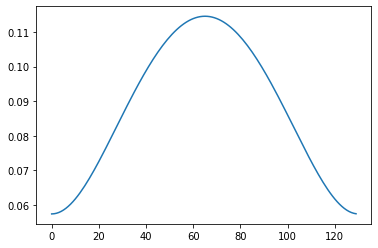





245


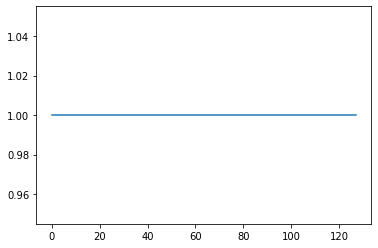

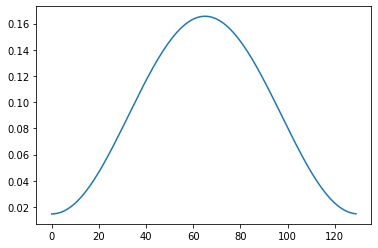





246


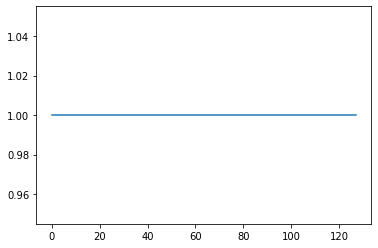

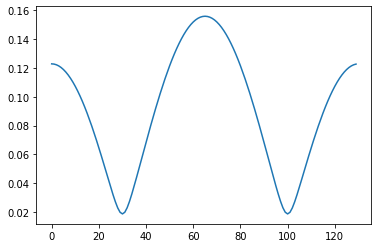





247


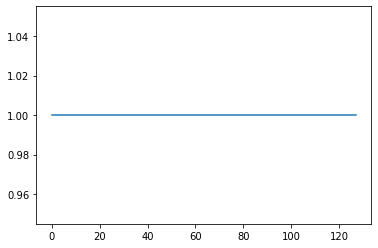

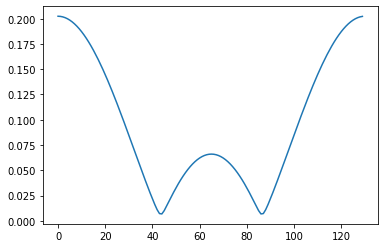





248


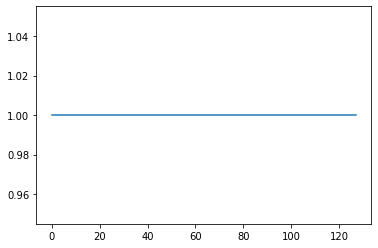

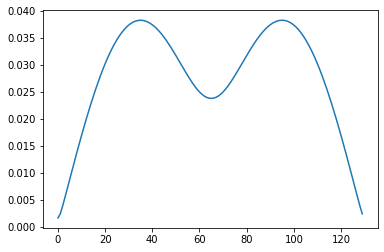





249


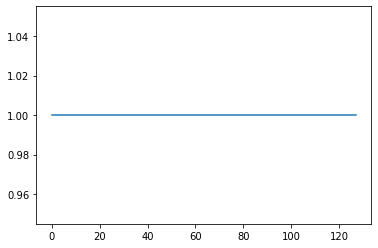

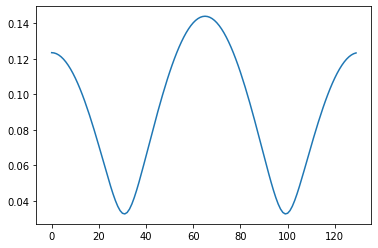





250


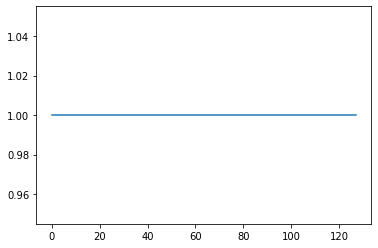

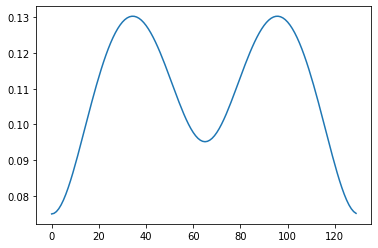





251


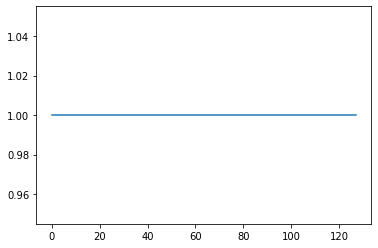

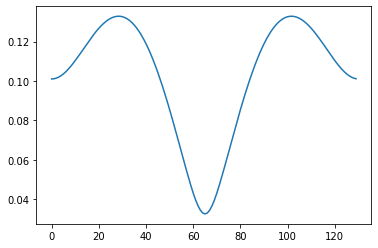





252


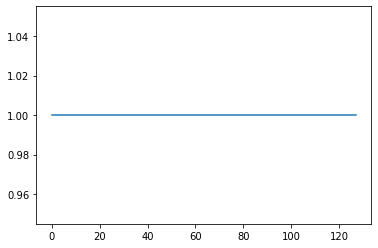

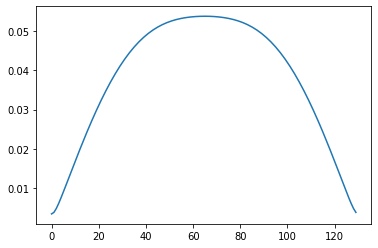





253


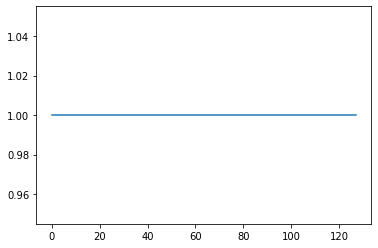

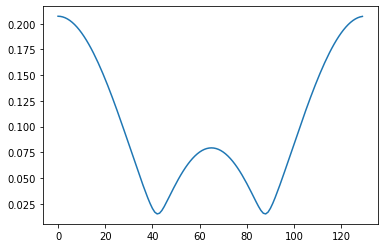





254


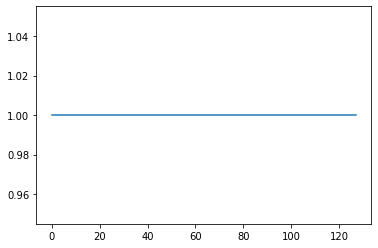

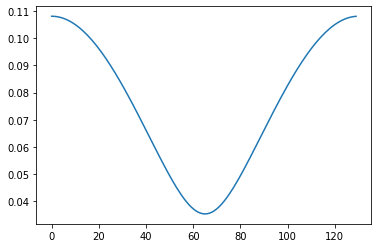





255


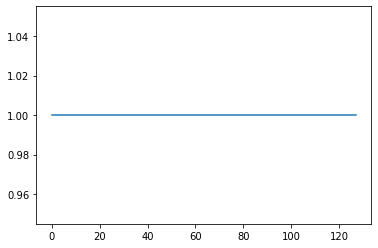

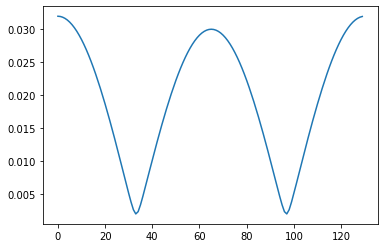

In [ ]:
import scipy.signal
for i in range(256):
  X = np.zeros([2,128])
  X[0,0] = 1
  Y = scipy.signal.convolve2d(X,enw[0][:,:,0,i])
  print(i)
  fft(X)
  fft(Y)
  print("\n\n\n")

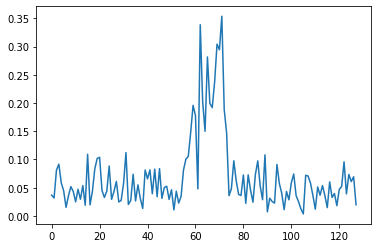

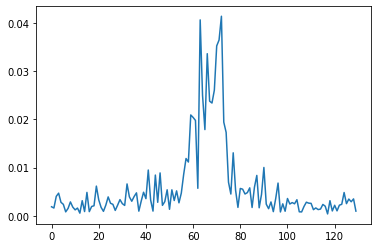

In [ ]:
1*3*5*256

3840

In [ ]:
def fft(X):
  X1 = X[0,:] + 1j*X[1,:]
  plt.plot(np.abs(np.fft.fftshift(np.fft.fft(X1))))
  plt.show()

In [ ]:
enw[1]

array([-8.56940809e-04, -8.29964131e-03, -6.27315789e-03, -4.37485240e-02,
        7.31838215e-03,  8.47003248e-04, -9.06121172e-03, -7.09763821e-03,
       -3.78036289e-03, -4.66113677e-03, -2.23642066e-02, -2.03461926e-02,
       -5.46316244e-02, -1.44338497e-04, -5.36677195e-04, -1.18314661e-02,
       -5.65332407e-03, -9.86171141e-03, -7.36442721e-03, -2.25203820e-02,
       -7.10183755e-03,  9.88533068e-03, -3.29978727e-02,  6.99931523e-03,
       -7.61541305e-04, -2.90489756e-02, -4.76341881e-02, -1.07514334e-03,
       -5.39413514e-03, -2.01786011e-02, -7.02204090e-03, -6.00590603e-04,
       -3.12569388e-03, -1.04661081e-02, -1.56708397e-02, -5.76842017e-02,
       -4.31713685e-02, -5.29590482e-03, -2.58809291e-02, -2.22435426e-02,
       -2.56738942e-02, -3.17766890e-02,  2.05026125e-03, -8.25874787e-03,
       -4.49517416e-03, -4.49166773e-03, -3.09308385e-03,  1.87414140e-03,
       -1.30793368e-02, -2.66227499e-02, -4.52874787e-03, -9.47697740e-03,
       -3.93314436e-02, -

In [ ]:
X_test.shape

(55027, 2, 128)

In [ ]:
eps = np.linspace(0,3e-3,10)
OP = []
for __ in eps:
  X_Adv = fast_gradient_method(vae, X_test[:5000], __, np.inf)
  Y_pred = np.argmax(vae(X_test),axis=1)
  Y_test2 = np.argmax(Y_test,axis=1)
  co = 0
  for i in range(10000):
    if(Y_test2[i]==Y_pred[i]):
      co+=1
  print(co)
  OP.append(co/len(X_test))

0.1844890510948905


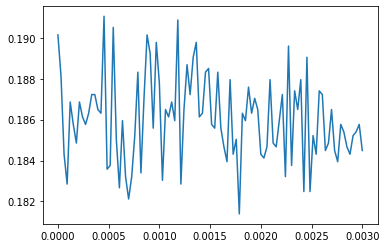

In [ ]:
plt.plot(eps,OP)
Y_pred = np.argmax(vae(X_test),axis=1)
Y_test2 = np.argmax(Y_test,axis=1)
co = 0
for i in range(len(X_test)):
  if(Y_test2[i]==Y_pred[i]):
    co+=1
print(co/len(X_test))

In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.savefig('%s Training performance' % (name))
# plt.show()

model.load_weights(filepath)
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print('evaluate_score:', score)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)
    # plt.show()


# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)

# %%č°ç¨ĺşäş§çćˇˇćˇçŠéľ
pre_labels = []
for x in test_Y_hat:
    tmp = np.argmax(x, 0)
    pre_labels.append(tmp)
true_labels = []
for x in Y_test:
    tmp = np.argmax(x, 0)
    true_labels.append(tmp)

kappa = cohen_kappa_score(pre_labels, true_labels)
oa = accuracy_score(true_labels, pre_labels)
kappa_oa = {}
print('oa_all:', oa)
print('kappa_all:', kappa)
kappa_oa['oa_all'] = oa
kappa_oa['kappa_all'] = kappa
fd = open('results_all_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, kappa_oa), fd)
fd.close()
cnf_matrix = confusion_matrix(true_labels, pre_labels)
# np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
# plt.figure()
plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                             normalize=False,
                             title='%s Confusion matrix, without normalization' % (name), showtext=True)
plt.savefig('%s Confusion matrix, without normalization' % (name))
# Plot normalized confusion matrix
# plt.figure()
plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                             normalize=True,
                             title='%s Normalized confusion matrix' % (name), showtext=True)
plt.savefig('%s Normalized confusion matrix' % (name))
# plt.show()

# %%čŞĺŽäšäş§çćˇˇćˇçŠéľ
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i, :]).index(1)
    k = int(np.argmax(test_Y_hat[i, :]))
    conf[j, k] += 1
for i in range(0, len(classes)):
    confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
plot_confusion_matrix(confnorm, labels=classes,
                      title='%s Confusion matrix' % (name))

# %%Plot confusion matrix çťĺž
acc = {}
kappa_dict = {}
oa_dict = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)

    # %%č°ç¨ĺşäş§çćˇˇćˇçŠéľ
    pre_labels_i = []
    for x in test_Y_i_hat:
        tmp = np.argmax(x, 0)
        pre_labels_i.append(tmp)
    true_labels_i = []
    for x in test_Y_i:
        tmp = np.argmax(x, 0)
        true_labels_i.append(tmp)
    kappa = cohen_kappa_score(pre_labels_i, true_labels_i)
    oa = accuracy_score(true_labels_i, pre_labels_i)
    oa_dict[snr] = oa
    kappa_dict[snr] = kappa
    cnf_matrix = confusion_matrix(true_labels_i, pre_labels_i)
    # np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    # plt.figure()
    plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                                 normalize=False,
                                 title='%s Confusion matrix, without normalization (SNR=%d)' % (name, snr), showtext=True)
    plt.savefig('%s Confusion matrix, without normalization (SNR=%d)' %
                (name, snr))
    # Plot normalized confusion matrix
    # plt.figure()
    plotcm.plot_confusion_matrix(cnf_matrix, classes=classes,
                                 normalize=True,
                                 title='%s Normalized confusion matrix (SNR=%d)' % (name, snr), showtext=True)
    plt.savefig('%s Normalized confusion matrix (SNR=%d)' % (name, snr))
    # plt.show()

    # %%čŞĺŽäšäş§çćˇˇćˇçŠéľ
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] += 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    # plt.figure()
    plot_confusion_matrix(confnorm, labels=classes,
                          title="%s Confusion Matrix (SNR=%d)" % (name, snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)

# %%Save results to a pickle file for plotting later
print 'acc:', acc
fd = open('results_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, acc), fd)
fd.close()
print('oa:', oa_dict)
fd = open('results_oa_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, oa_dict), fd)
fd.close()
print('kappa:', kappa_dict)
fd = open('results_kappa_%s_d0.5.dat' % (name), 'wb')
cPickle.dump(("%s" % (name), 0.5, kappa_dict), fd)
fd.close()

# %%Plot accuracy curve
plt.figure()
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("%s Classification Accuracy on RadioML 2016.10 Alpha" % (name))
plt.savefig("%s Classification Accuracy" % (name))
# plt.show()

In [ ]:
from transmitters import transmitters
from source_alphabet import source_alphabet
import analyze_stats
from gnuradio import channels, gr, blocks
import numpy as np
import numpy.fft, cPickle, gzip
import random

'''
Generate dataset with dynamic channel model across range of SNRs
'''

apply_channel = True

dataset = {}

# The output format looks like this
# {('mod type', SNR): np.array(nvecs_per_key, 2, vec_length), etc}

# CIFAR-10 has 6000 samples/class. CIFAR-100 has 600. Somewhere in there seems like right order of magnitude
nvecs_per_key = 1000
vec_length = 128
snr_vals = range(-20,20,2)
for snr in snr_vals:
    print "snr is ", snr
    for alphabet_type in transmitters.keys():
        for i,mod_type in enumerate(transmitters[alphabet_type]):
          dataset[(mod_type.modname, snr)] = np.zeros([nvecs_per_key, 2, vec_length], dtype=np.float32)
          # moar vectors!
          insufficient_modsnr_vectors = True
          modvec_indx = 0
          while insufficient_modsnr_vectors:
              tx_len = int(10e3)
              if mod_type.modname == "QAM16":
                  tx_len = int(20e3)
              if mod_type.modname == "QAM64":
                  tx_len = int(30e3)
              src = source_alphabet(alphabet_type, tx_len, True)
              mod = mod_type()
              fD = 1
              delays = [0.0, 0.9, 1.7]
              mags = [1, 0.8, 0.3]
              ntaps = 8
              noise_amp = 10**(-snr/10.0)
              chan = channels.dynamic_channel_model( 200e3, 0.01, 50, .01, 0.5e3, 8, fD, True, 4, delays, mags, ntaps, noise_amp, 0x1337 )

              snk = blocks.vector_sink_c()

              tb = gr.top_block()

              # connect blocks
              if apply_channel:
                  tb.connect(src, mod, chan, snk)
              else:
                  tb.connect(src, mod, snk)
              tb.run()

              raw_output_vector = np.array(snk.data(), dtype=np.complex64)
              # start the sampler some random time after channel model transients (arbitrary values here)
              sampler_indx = random.randint(50, 500)
              while sampler_indx + vec_length < len(raw_output_vector) and modvec_indx < nvecs_per_key:
                  sampled_vector = raw_output_vector[sampler_indx:sampler_indx+vec_length]
                  # Normalize the energy in this vector to be 1
                  energy = np.sum((np.abs(sampled_vector)))
                  sampled_vector = sampled_vector / energy
                  dataset[(mod_type.modname, snr)][modvec_indx,0,:] = np.real(sampled_vector)
                  dataset[(mod_type.modname, snr)][modvec_indx,1,:] = np.imag(sampled_vector)
                  # bound the upper end very high so it's likely we get multiple passes through
                  # independent channels
                  sampler_indx += random.randint(vec_length, round(len(raw_output_vector)*.05))
                  modvec_indx += 1

              if modvec_indx == nvecs_per_key:
                  # we're all done
                  insufficient_modsnr_vectors = False

print "all done. writing to disk"
cPickle.dump( dataset, file("RML2016.10a_dict.dat", "wb" ))

SyntaxError: ignored